# T81-558: Applications of Deep Neural Networks
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

**Kaggle Assignment: **

**Student Name: Jason Walker**

# Overview

## Description
This is one of the projects from the course T81-855: Applications of Deep Learning at Washington University in St. Louis. All students must create a Kaggle account and submit a solution. Once you have submitted your solution entry log into Blackboard (at WUSTL) and submit a single file telling me your Kaggle name on the leaderboard (you do not need to register to Kaggle with your real name). This competition will be visible to the public, so there may be non-student submissions as well as student.

The data set for this competition consists of a number of input columns that should be used to predict a stores sales. This is a regression problem. The inputs are a mixture of discrete and category values. The data set is from a simulation.

## Evaluation

The evaluation pages describes how submissions will be scored and how students should format their submissions. The scores are in RMSE.
Submission Format

For every store in the dataset, submission files should contain a sales volume.

The file should contain a header and have the following format:

```
100000,1.23
100001,1.123
100002,3.332
100003,1.53
...
```

# Data

## Data Description

The data contains data and costs for various office supplies. The data came from a simulation and do not directly correspond to any real-world items. See how well you can predict the cost of an item using the provided data. Feature engineering will likely help you. The *name* column may seem useless at first glance; however, it contains information that you can parse to help your predictions.
File descriptions
```
    id - The identifier/primary key.
    name - The name of this item.
    manufacturer - The manufacturer.
    pack - The number of items in this pack.
    weight - The weight of a pack of these items.
    height - The height of a pack of these items.
    width - The width of a pack of these items.
    length - The length of a pack of these items.
    cost - The cost for this item pack. This is what you are to predict (the target). 
```

# Helpful Functions

You will see these at the top of every module and assignment.  These are simply a set of reusable functions that we will make use of.  Each of them will be explained as the semester progresses.  They are explained in greater detail as the course progresses.  Class 4 contains a complete overview of these functions.

In [3]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
        
# This function submits an assignment.  You can submit an assignment as much as you like, only the final
# submission counts.  The paramaters are as follows:
# data - Pandas dataframe output.
# key - Your student key that was emailed to you.
# no - The assignment class number, should be 1 through 1.
# source_file - The full path to your Python or IPYNB file.  This must have "_class1" as part of its name.  
# .             The number must match your assignment number.  For example "_class2" for class assignment #2.
def submit(data,key,no,source_file=None):
    if source_file is None and '__file__' not in globals(): raise Exception('Must specify a filename when a Jupyter notebook.')
    if source_file is None: source_file = __file__
    suffix = '_class{}'.format(no)
    if suffix not in source_file: raise Exception('{} must be part of the filename.'.format(suffix))
    with open(source_file, "rb") as image_file:
        encoded_python = base64.b64encode(image_file.read()).decode('ascii')
    ext = os.path.splitext(source_file)[-1].lower()
    if ext not in ['.ipynb','.py']: raise Exception("Source file is {} must be .py or .ipynb".format(ext))
    r = requests.post("https://api.heatonresearch.com/assignment-submit",
        headers={'x-api-key':key}, json={'csv':base64.b64encode(data.to_csv(index=False).encode('ascii')).decode("ascii"),
        'assignment': no, 'ext':ext, 'py':encoded_python})
    if r.status_code == 200:
        print("Success: {}".format(r.text))
    else: print("Failure: {}".format(r.text))

# Kaggle Code

## Load Data and Encode


In [12]:
import os
import re
import sklearn

import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn import metrics
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split, KFold
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers

path = './data'

filename_test = os.path.join(path,"test.csv")
filename_train = os.path.join(path,"train.csv")
filename_sample = os.path.join(path,"sample.csv")
filename_submit = os.path.join(path,"submit.csv")
filename_checkpoint = os.path.join(path,"checkpoint.hdf5")

df_train = pd.read_csv(filename_train,na_values=['NA','?'])

np.random.seed(42) # Uncomment this line to get the same shuffle each time
df_train = df_train.reindex(np.random.permutation(df_train.index))
df_train.reset_index(inplace=True, drop=True)

# Encode Features

# Remove all rows where the specified column is +/- sd standard deviations
def extract_and_encode_features(df):
    color_regex='(?P<color>red|blue|green|yellow|orange|pink|black|brown|white)'
    df['color'] = df.name.str.extract(color_regex, flags=re.IGNORECASE, expand=False)

    quality_regex='(?P<quality>generic|high\squality)'
    df['quality'] = df.name.str.extract(quality_regex, flags=re.IGNORECASE, expand=False)

    size_regex='(?P<size>tiny|small|medium|large)'
    df['size'] = df.name.str.extract(size_regex, flags=re.IGNORECASE, expand=False)

    item_regex='(?P<item>paperclips|paperweights|ink\spens|pencils|stapler|tablets|thumbtacks|post\sit\snotes)'
    df['item'] = df.name.str.extract(item_regex, flags=re.IGNORECASE, expand=False)
    
    for column in ['pack','weight','height','width','length']:
        missing_median(df,column)
    
    df.insert(1,'surface_area',(df['height']*df['width']*df['length']).astype(np.float32))
    
    for column in ['height','width','length']:
        df.drop(column,1,inplace=True)
    
    ## encode numeric features
    for column in ['pack','weight','surface_area']:
        encode_numeric_zscore(df,column)

    # encode text/categorical features
    for column in ['manufacturer','color','quality','size','item']:
        encode_text_dummy(df,column)
  
extract_and_encode_features(df_train)

ids_train = df_train['id']
df_train.drop('id',1,inplace=True)

names_train = df_train['name']
df_train.drop('name',1,inplace=True)

x,y = to_xy(df_train,'cost')

# Used before KFold
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45)


In [11]:
print(df_train[0:10])

   surface_area      pack    weight    cost  manufacturer-6% Solution  \
0     -0.391150 -0.580980 -0.442755   76.74                         0   
1      1.148394 -1.042627 -0.870281   65.21                         0   
2     -0.781008  1.138882  0.355983  192.47                         1   
3      0.476087 -0.490461 -0.138201  161.12                         0   
4      2.011652 -1.057713 -0.892117   21.34                         0   
5      0.476087 -1.057713 -0.894416   21.34                         1   
6     -0.781008  1.681997  0.666284  224.41                         1   
7     -0.781008  0.716460  0.114637  176.66                         1   
8     -0.884440 -0.930987 -0.877177    8.48                         0   
9     -0.781008 -0.864606 -0.788684   19.56                         0   

   manufacturer-Deep Office Supplies  manufacturer-Duck Lake  \
0                                  1                       0   
1                                  0                       0   
2   

## Linear Regression (Coefficients)

Final score (RMSE): 32.602088928222656
['surface_area', 'pack', 'weight', 'manufacturer-6% Solution', 'manufacturer-Deep Office Supplies', 'manufacturer-Duck Lake', 'manufacturer-Offices-R-Us', 'manufacturer-WizBang', 'color-Black', 'color-Blue', 'color-Brown', 'color-Green', 'color-Pink', 'color-Red', 'color-White', 'quality-Generic', 'quality-High Quality', 'size-Large', 'size-Medium', 'size-Small', 'size-Tiny', 'item-Ink Pens', 'item-Paperclips', 'item-Paperweights', 'item-Pencils', 'item-Post It Notes', 'item-Stapler', 'item-Tablets', 'item-Thumbtacks']


,coef,positive
item-Pencils,-118.101379,False
item-Thumbtacks,-114.043709,False
item-Paperweights,-101.276184,False
item-Post It Notes,-97.399124,False
item-Paperclips,-91.027069,False
item-Ink Pens,-83.828979,False
item-Stapler,-75.198425,False
color-Red,-38.204388,False
color-Green,-26.037094,False
size-Large,-12.952026,False


Intercept: [-754.47357178]


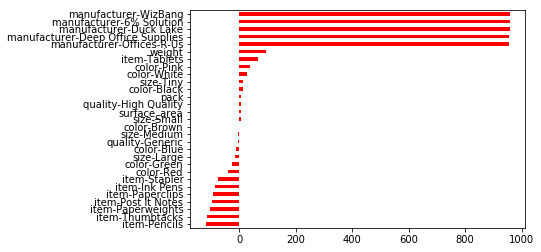

In [13]:
# Simple function to evaluate the coefficients of a regression
%matplotlib inline    
from IPython.display import display, HTML    

def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))
    
# Create linear regression
regressor = sklearn.linear_model.LinearRegression()

# Fit/train linear regression
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df_train.columns.values)
names.remove("cost")
print(names)
report_coef(
  names,
  regressor.coef_[0,:],
  regressor.intercept_)

## L1 Regularization (Lasso)

Final score (RMSE): 32.6033821105957


,coef,positive
color-Red,-38.011356,False
item-Pencils,-26.881954,False
color-Green,-25.850136,False
item-Thumbtacks,-22.845032,False
size-Large,-12.851401,False
color-Blue,-11.689812,False
item-Paperweights,-9.976925,False
item-Post It Notes,-6.170481,False
quality-Generic,-4.635770,False
size-Medium,-2.924804,False


Intercept: [ 112.45285034]


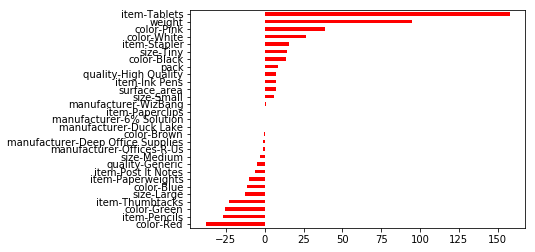

In [14]:


import sklearn
from sklearn.linear_model import Lasso

# Create linear regression
regressor = Lasso(random_state=0,alpha=0.01)

# Fit/train LASSO
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df_train.columns.values)
names.remove("cost")
report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)



## L1 Regularization (Plot LassoCV)

/Users/jwalker/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jwalker/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jwalker/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jwalker/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

(1e-08, 100000000.0)

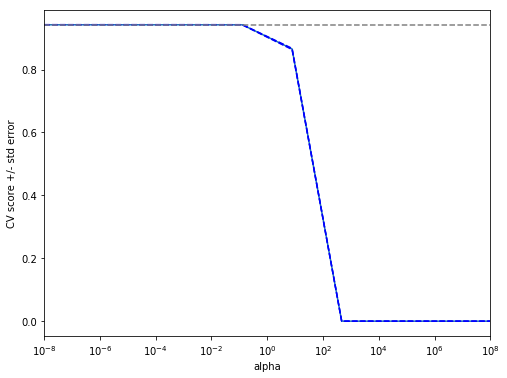

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

lasso = Lasso(random_state=42)
alphas = np.logspace(-8, 8, 10)

scores = list()
scores_std = list()

n_folds = 3

for alpha in alphas:
    lasso.alpha = alpha
    this_scores = cross_val_score(lasso, x, y, cv=n_folds, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

## L2 Regularization (Ridge)

Final score (RMSE): 32.60321044921875


,coef,positive
item-Pencils,-41.270035,False
color-Red,-38.166615,False
item-Thumbtacks,-37.185127,False
color-Green,-26.017801,False
item-Paperweights,-24.549904,False
item-Post It Notes,-20.518717,False
item-Paperclips,-14.165739,False
size-Large,-13.026008,False
color-Blue,-11.871177,False
item-Ink Pens,-7.076108,False


Intercept: [ 126.84092712]


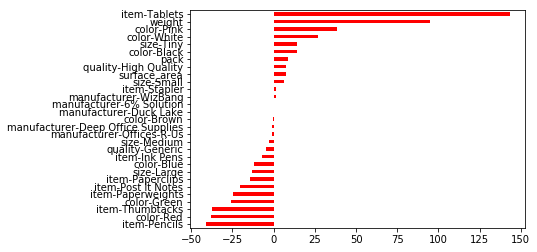

In [16]:
import sklearn
from sklearn.linear_model import Ridge

# Create linear regression
regressor = Ridge(alpha=1)

# Fit/train Ridge
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df_train.columns.values)
names.remove("cost")

report_coef(
  names,
  regressor.coef_[0,:],
  regressor.intercept_)

## ElasticNet Regularization

Final score (RMSE): 32.942909240722656


,coef,positive
item-Pencils,-37.769466,False
color-Red,-35.675865,False
item-Thumbtacks,-33.047462,False
color-Green,-24.636555,False
item-Paperweights,-24.466547,False
size-Large,-15.412159,False
item-Post It Notes,-15.068984,False
color-Blue,-11.372995,False
item-Paperclips,-10.843545,False
item-Ink Pens,-7.129179,False


Intercept: [ 127.57927704]


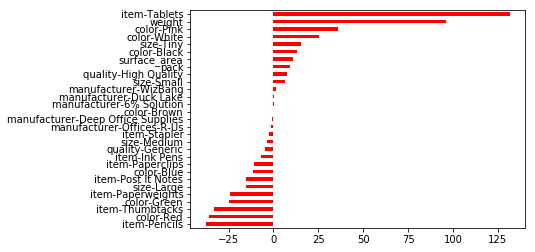

In [17]:
import sklearn
from sklearn.linear_model import ElasticNet

# Create linear regression
regressor = ElasticNet(alpha=0.01, l1_ratio=0.1)

# Fit/train LASSO
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df_train.columns.values)
names.remove("cost")

report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)

## Generate Training Model

In [18]:
# Cross-Validate
kf = KFold(5)

checkpoint = ModelCheckpoint(filepath=filename_checkpoint, verbose=0, save_best_only=True)

# Turn off KFold
#if (0):
oos_y = []
oos_pred = []
fold = 0
    
for train, test in kf.split(x):
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model.add(Dropout(0.01)) # Dropout Layer 1
    model.add(Dense(50, activation='relu')) # Hidden 2
    #model.add(Dropout(0.01)) # Dropout Layer 2
    model.add(Dense(25, 
                    kernel_regularizer=regularizers.l2(0.01), #L2 regularization
                    activity_regularizer=regularizers.l1(0.01), #L1 Lasso regularization
                    activation='relu')) # Hidden 3 
    model.add(Dense(10, activation='relu')) # Hidden 4
    model.add(Dense(1)) # Output
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=1000, verbose=1, mode='auto')
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpoint],verbose=1,epochs=10000)
    
    pred = model.predict(x_test)
    
    oos_y.append(y_test)
    oos_pred.append(pred)        

    # Measure this fold's RMSE
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Fold score (RMSE): {}".format(score))


Fold #1
Train on 8000 samples, validate on 2000 samples
Epoch 1/10000
8000/8000 [==============================] - 1s 119us/step - loss: 12627.2007 - val_loss: 1079.7828
Epoch 2/10000
8000/8000 [==============================] - 0s 60us/step - loss: 733.0681 - val_loss: 555.3366
Epoch 3/10000
8000/8000 [==============================] - 0s 59us/step - loss: 440.4139 - val_loss: 389.7372
Epoch 4/10000
8000/8000 [==============================] - 1s 65us/step - loss: 344.7600 - val_loss: 340.7027
Epoch 5/10000
8000/8000 [==============================] - 1s 63us/step - loss: 316.0309 - val_loss: 331.2599
Epoch 6/10000
8000/8000 [==============================] - 0s 60us/step - loss: 300.7299 - val_loss: 316.1182
Epoch 7/10000
8000/8000 [==============================] - 0s 59us/step - loss: 293.1848 - val_loss: 303.3080
Epoch 8/10000
8000/8000 [==============================] - 0s 60us/step - loss: 283.3550 - val_loss: 291.2142
Epoch 9/10000
8000/8000 [==============================] - 0

8000/8000 [==============================] - 1s 111us/step - loss: 168.9218 - val_loss: 237.3352
Epoch 75/10000
8000/8000 [==============================] - 1s 160us/step - loss: 170.6176 - val_loss: 261.1483
Epoch 76/10000
8000/8000 [==============================] - 1s 101us/step - loss: 173.0507 - val_loss: 240.0261
Epoch 77/10000
8000/8000 [==============================] - 1s 72us/step - loss: 168.9815 - val_loss: 238.2473
Epoch 78/10000
8000/8000 [==============================] - 1s 67us/step - loss: 160.7179 - val_loss: 230.4188
Epoch 79/10000
8000/8000 [==============================] - 1s 95us/step - loss: 167.9766 - val_loss: 240.6996
Epoch 80/10000
8000/8000 [==============================] - 1s 129us/step - loss: 163.8039 - val_loss: 234.3336
Epoch 81/10000
8000/8000 [==============================] - 1s 85us/step - loss: 165.6244 - val_loss: 232.1388
Epoch 82/10000
8000/8000 [==============================] - 0s 59us/step - loss: 161.0219 - val_loss: 244.6321
Epoch 83/100

8000/8000 [==============================] - 0s 52us/step - loss: 106.8520 - val_loss: 187.4934
Epoch 148/10000
8000/8000 [==============================] - 0s 51us/step - loss: 103.7740 - val_loss: 202.3160
Epoch 149/10000
8000/8000 [==============================] - 0s 52us/step - loss: 104.7920 - val_loss: 200.5417
Epoch 150/10000
8000/8000 [==============================] - 0s 51us/step - loss: 103.3179 - val_loss: 179.9276
Epoch 151/10000
8000/8000 [==============================] - 0s 61us/step - loss: 101.0710 - val_loss: 216.6587
Epoch 152/10000
8000/8000 [==============================] - 1s 70us/step - loss: 104.4964 - val_loss: 208.3902
Epoch 153/10000
8000/8000 [==============================] - 1s 74us/step - loss: 104.2245 - val_loss: 202.0151
Epoch 154/10000
8000/8000 [==============================] - 1s 63us/step - loss: 97.8174 - val_loss: 255.6452
Epoch 155/10000
8000/8000 [==============================] - 1s 77us/step - loss: 103.9478 - val_loss: 203.1953
Epoch 156

Epoch 221/10000
8000/8000 [==============================] - 0s 54us/step - loss: 74.2813 - val_loss: 198.3582
Epoch 222/10000
8000/8000 [==============================] - 0s 60us/step - loss: 74.0317 - val_loss: 201.0242
Epoch 223/10000
8000/8000 [==============================] - 0s 54us/step - loss: 72.4776 - val_loss: 199.3984
Epoch 224/10000
8000/8000 [==============================] - 0s 60us/step - loss: 74.6160 - val_loss: 202.3717
Epoch 225/10000
8000/8000 [==============================] - 0s 59us/step - loss: 74.3866 - val_loss: 186.3611
Epoch 226/10000
8000/8000 [==============================] - 1s 70us/step - loss: 70.1977 - val_loss: 197.5994
Epoch 227/10000
8000/8000 [==============================] - 1s 75us/step - loss: 67.9853 - val_loss: 181.8167
Epoch 228/10000
8000/8000 [==============================] - 1s 74us/step - loss: 70.1706 - val_loss: 181.6167
Epoch 229/10000
8000/8000 [==============================] - 0s 57us/step - loss: 69.5560 - val_loss: 187.6711
E

Epoch 295/10000
8000/8000 [==============================] - 1s 76us/step - loss: 59.1973 - val_loss: 188.5092
Epoch 296/10000
8000/8000 [==============================] - 1s 85us/step - loss: 57.2581 - val_loss: 185.1170
Epoch 297/10000
8000/8000 [==============================] - 1s 77us/step - loss: 61.3577 - val_loss: 207.0631
Epoch 298/10000
8000/8000 [==============================] - 1s 67us/step - loss: 59.9653 - val_loss: 190.6641
Epoch 299/10000
8000/8000 [==============================] - 1s 79us/step - loss: 57.1786 - val_loss: 180.0150
Epoch 300/10000
8000/8000 [==============================] - 1s 67us/step - loss: 55.6184 - val_loss: 184.9666
Epoch 301/10000
8000/8000 [==============================] - 1s 79us/step - loss: 53.7501 - val_loss: 201.0857
Epoch 302/10000
8000/8000 [==============================] - 1s 67us/step - loss: 56.8071 - val_loss: 211.8916
Epoch 303/10000
8000/8000 [==============================] - 1s 68us/step - loss: 58.2411 - val_loss: 185.2928
E

Epoch 369/10000
8000/8000 [==============================] - 1s 67us/step - loss: 48.8860 - val_loss: 196.8473
Epoch 370/10000
8000/8000 [==============================] - 0s 53us/step - loss: 58.4882 - val_loss: 181.0124
Epoch 371/10000
8000/8000 [==============================] - 0s 55us/step - loss: 50.0434 - val_loss: 175.5257
Epoch 372/10000
8000/8000 [==============================] - 1s 65us/step - loss: 52.4537 - val_loss: 180.8307
Epoch 373/10000
8000/8000 [==============================] - 1s 66us/step - loss: 49.9693 - val_loss: 174.4912
Epoch 374/10000
8000/8000 [==============================] - 0s 54us/step - loss: 49.5423 - val_loss: 194.2439
Epoch 375/10000
8000/8000 [==============================] - 0s 54us/step - loss: 48.0779 - val_loss: 174.8052
Epoch 376/10000
8000/8000 [==============================] - 0s 53us/step - loss: 47.0760 - val_loss: 186.6531
Epoch 377/10000
8000/8000 [==============================] - 0s 52us/step - loss: 50.8070 - val_loss: 206.2346
E

Epoch 443/10000
8000/8000 [==============================] - 0s 56us/step - loss: 47.8289 - val_loss: 200.6794
Epoch 444/10000
8000/8000 [==============================] - 0s 57us/step - loss: 45.8431 - val_loss: 173.3500
Epoch 445/10000
8000/8000 [==============================] - 1s 86us/step - loss: 44.2541 - val_loss: 167.1894
Epoch 446/10000
8000/8000 [==============================] - 1s 67us/step - loss: 41.0314 - val_loss: 175.4190
Epoch 447/10000
8000/8000 [==============================] - 0s 56us/step - loss: 45.3691 - val_loss: 189.8141
Epoch 448/10000
8000/8000 [==============================] - 0s 54us/step - loss: 52.3873 - val_loss: 193.1510
Epoch 449/10000
8000/8000 [==============================] - 0s 51us/step - loss: 43.9409 - val_loss: 177.4492
Epoch 450/10000
8000/8000 [==============================] - 0s 61us/step - loss: 40.6407 - val_loss: 180.1035
Epoch 451/10000
8000/8000 [==============================] - 1s 68us/step - loss: 42.6382 - val_loss: 175.0186
E

Epoch 517/10000
8000/8000 [==============================] - 0s 58us/step - loss: 41.3715 - val_loss: 180.7538
Epoch 518/10000
8000/8000 [==============================] - 0s 54us/step - loss: 38.3833 - val_loss: 176.0811
Epoch 519/10000
8000/8000 [==============================] - 1s 68us/step - loss: 36.8836 - val_loss: 181.3620
Epoch 520/10000
8000/8000 [==============================] - 1s 70us/step - loss: 49.3199 - val_loss: 176.4944
Epoch 521/10000
8000/8000 [==============================] - 1s 68us/step - loss: 39.2989 - val_loss: 186.0292
Epoch 522/10000
8000/8000 [==============================] - 0s 57us/step - loss: 40.1389 - val_loss: 178.0488
Epoch 523/10000
8000/8000 [==============================] - 0s 53us/step - loss: 38.2865 - val_loss: 183.3328
Epoch 524/10000
8000/8000 [==============================] - 1s 77us/step - loss: 42.6366 - val_loss: 186.9338
Epoch 525/10000
8000/8000 [==============================] - 1s 79us/step - loss: 39.9761 - val_loss: 189.8753
E

8000/8000 [==============================] - 1s 81us/step - loss: 36.7529 - val_loss: 177.2741
Epoch 591/10000
8000/8000 [==============================] - 1s 76us/step - loss: 37.6566 - val_loss: 174.8288
Epoch 592/10000
8000/8000 [==============================] - 1s 73us/step - loss: 40.4923 - val_loss: 173.7862
Epoch 593/10000
8000/8000 [==============================] - 1s 72us/step - loss: 38.0743 - val_loss: 169.3288
Epoch 594/10000
8000/8000 [==============================] - 1s 73us/step - loss: 36.3452 - val_loss: 182.4244
Epoch 595/10000
8000/8000 [==============================] - 1s 96us/step - loss: 35.6313 - val_loss: 177.4043
Epoch 596/10000
8000/8000 [==============================] - 1s 74us/step - loss: 34.7717 - val_loss: 176.5626
Epoch 597/10000
8000/8000 [==============================] - 1s 71us/step - loss: 36.9023 - val_loss: 185.4315
Epoch 598/10000
8000/8000 [==============================] - 1s 70us/step - loss: 37.6952 - val_loss: 177.4087
Epoch 599/10000
8

Epoch 664/10000
8000/8000 [==============================] - 1s 98us/step - loss: 33.8288 - val_loss: 185.9444
Epoch 665/10000
8000/8000 [==============================] - 1s 87us/step - loss: 39.1686 - val_loss: 178.6730
Epoch 666/10000
8000/8000 [==============================] - 1s 87us/step - loss: 33.6657 - val_loss: 176.2262
Epoch 667/10000
8000/8000 [==============================] - 1s 83us/step - loss: 36.0276 - val_loss: 174.0564
Epoch 668/10000
8000/8000 [==============================] - 1s 80us/step - loss: 35.1812 - val_loss: 178.0019
Epoch 669/10000
8000/8000 [==============================] - 1s 101us/step - loss: 32.8655 - val_loss: 180.2300
Epoch 670/10000
8000/8000 [==============================] - 1s 114us/step - loss: 32.1214 - val_loss: 168.2715
Epoch 671/10000
8000/8000 [==============================] - 1s 84us/step - loss: 34.1427 - val_loss: 178.6555
Epoch 672/10000
8000/8000 [==============================] - 1s 112us/step - loss: 32.5019 - val_loss: 175.104

8000/8000 [==============================] - 0s 60us/step - loss: 32.9083 - val_loss: 172.9202
Epoch 738/10000
8000/8000 [==============================] - 0s 52us/step - loss: 30.3246 - val_loss: 179.2284
Epoch 739/10000
8000/8000 [==============================] - 0s 51us/step - loss: 31.9551 - val_loss: 174.7016
Epoch 740/10000
8000/8000 [==============================] - 0s 61us/step - loss: 33.6621 - val_loss: 175.9029
Epoch 741/10000
8000/8000 [==============================] - 0s 55us/step - loss: 31.0429 - val_loss: 162.7271
Epoch 742/10000
8000/8000 [==============================] - 0s 56us/step - loss: 33.2709 - val_loss: 181.2246
Epoch 743/10000
8000/8000 [==============================] - 0s 53us/step - loss: 30.8020 - val_loss: 177.5405
Epoch 744/10000
8000/8000 [==============================] - 0s 55us/step - loss: 31.2033 - val_loss: 173.5247
Epoch 745/10000
8000/8000 [==============================] - 0s 50us/step - loss: 32.9498 - val_loss: 181.3262
Epoch 746/10000
8

Epoch 811/10000
8000/8000 [==============================] - 0s 50us/step - loss: 30.2332 - val_loss: 181.7656
Epoch 812/10000
8000/8000 [==============================] - 0s 55us/step - loss: 32.1119 - val_loss: 195.8243
Epoch 813/10000
8000/8000 [==============================] - 0s 52us/step - loss: 30.9188 - val_loss: 176.0051
Epoch 814/10000
8000/8000 [==============================] - 0s 52us/step - loss: 29.5236 - val_loss: 178.5186
Epoch 815/10000
8000/8000 [==============================] - 0s 51us/step - loss: 28.5999 - val_loss: 174.8517
Epoch 816/10000
8000/8000 [==============================] - 0s 51us/step - loss: 31.6482 - val_loss: 193.7436
Epoch 817/10000
8000/8000 [==============================] - 0s 52us/step - loss: 29.4442 - val_loss: 186.2563
Epoch 818/10000
8000/8000 [==============================] - 0s 49us/step - loss: 31.3913 - val_loss: 182.9997
Epoch 819/10000
8000/8000 [==============================] - 0s 59us/step - loss: 29.6233 - val_loss: 183.4332
E

Epoch 885/10000
8000/8000 [==============================] - 0s 51us/step - loss: 29.9224 - val_loss: 181.7542
Epoch 886/10000
8000/8000 [==============================] - 0s 53us/step - loss: 28.2503 - val_loss: 170.1251
Epoch 887/10000
8000/8000 [==============================] - 0s 52us/step - loss: 28.6215 - val_loss: 183.9006
Epoch 888/10000
8000/8000 [==============================] - 0s 51us/step - loss: 26.2171 - val_loss: 176.0893
Epoch 889/10000
8000/8000 [==============================] - 0s 57us/step - loss: 30.7162 - val_loss: 175.5282
Epoch 890/10000
8000/8000 [==============================] - 0s 52us/step - loss: 29.2897 - val_loss: 183.5859
Epoch 891/10000
8000/8000 [==============================] - 0s 54us/step - loss: 31.6601 - val_loss: 171.8708
Epoch 892/10000
8000/8000 [==============================] - 0s 50us/step - loss: 27.8447 - val_loss: 176.5968
Epoch 893/10000
8000/8000 [==============================] - 0s 53us/step - loss: 30.5581 - val_loss: 177.0536
E

8000/8000 [==============================] - 1s 92us/step - loss: 26.7424 - val_loss: 176.1353
Epoch 959/10000
8000/8000 [==============================] - 1s 69us/step - loss: 25.0139 - val_loss: 172.7437
Epoch 960/10000
8000/8000 [==============================] - 1s 64us/step - loss: 24.9374 - val_loss: 190.3782
Epoch 961/10000
8000/8000 [==============================] - 0s 61us/step - loss: 26.1749 - val_loss: 172.9393
Epoch 962/10000
8000/8000 [==============================] - 0s 59us/step - loss: 27.7831 - val_loss: 174.2149
Epoch 963/10000
8000/8000 [==============================] - 1s 63us/step - loss: 27.6097 - val_loss: 184.9502
Epoch 964/10000
8000/8000 [==============================] - 1s 63us/step - loss: 27.0084 - val_loss: 166.8564
Epoch 965/10000
8000/8000 [==============================] - 1s 65us/step - loss: 25.1339 - val_loss: 194.7766
Epoch 966/10000
8000/8000 [==============================] - 1s 65us/step - loss: 25.5968 - val_loss: 179.1591
Epoch 967/10000
8

8000/8000 [==============================] - 0s 59us/step - loss: 24.2144 - val_loss: 194.0802
Epoch 1032/10000
8000/8000 [==============================] - 0s 51us/step - loss: 25.9518 - val_loss: 178.7175
Epoch 1033/10000
8000/8000 [==============================] - 0s 49us/step - loss: 26.3696 - val_loss: 180.6691
Epoch 1034/10000
8000/8000 [==============================] - 0s 50us/step - loss: 28.1133 - val_loss: 174.1120
Epoch 1035/10000
8000/8000 [==============================] - 0s 51us/step - loss: 24.3453 - val_loss: 180.4313
Epoch 1036/10000
8000/8000 [==============================] - 0s 49us/step - loss: 25.2122 - val_loss: 188.0274
Epoch 1037/10000
8000/8000 [==============================] - 0s 55us/step - loss: 26.1894 - val_loss: 178.9834
Epoch 1038/10000
8000/8000 [==============================] - 0s 54us/step - loss: 25.0083 - val_loss: 184.1558
Epoch 1039/10000
8000/8000 [==============================] - 0s 59us/step - loss: 28.5545 - val_loss: 174.9804
Epoch 104

8000/8000 [==============================] - 1s 67us/step - loss: 23.1363 - val_loss: 180.3923
Epoch 1105/10000
8000/8000 [==============================] - 0s 62us/step - loss: 24.0299 - val_loss: 183.4514
Epoch 1106/10000
8000/8000 [==============================] - 1s 66us/step - loss: 23.6875 - val_loss: 180.6414
Epoch 1107/10000
8000/8000 [==============================] - 0s 60us/step - loss: 25.6566 - val_loss: 170.6096
Epoch 1108/10000
8000/8000 [==============================] - 0s 62us/step - loss: 24.1154 - val_loss: 171.8672
Epoch 1109/10000
8000/8000 [==============================] - 0s 62us/step - loss: 25.2603 - val_loss: 181.3729
Epoch 1110/10000
8000/8000 [==============================] - 0s 60us/step - loss: 24.5929 - val_loss: 178.4818
Epoch 1111/10000
8000/8000 [==============================] - 1s 66us/step - loss: 23.6319 - val_loss: 175.9205
Epoch 1112/10000
8000/8000 [==============================] - 1s 71us/step - loss: 24.0439 - val_loss: 179.8492
Epoch 111

Epoch 1177/10000
8000/8000 [==============================] - 1s 66us/step - loss: 23.9123 - val_loss: 183.2993
Epoch 1178/10000
8000/8000 [==============================] - 1s 68us/step - loss: 23.7336 - val_loss: 182.3908
Epoch 1179/10000
8000/8000 [==============================] - 1s 67us/step - loss: 22.2071 - val_loss: 180.8271
Epoch 1180/10000
8000/8000 [==============================] - 0s 62us/step - loss: 23.7985 - val_loss: 180.9782
Epoch 1181/10000
8000/8000 [==============================] - 1s 67us/step - loss: 22.8474 - val_loss: 174.5483
Epoch 1182/10000
8000/8000 [==============================] - 1s 98us/step - loss: 25.1494 - val_loss: 182.6350
Epoch 1183/10000
8000/8000 [==============================] - 1s 104us/step - loss: 23.5152 - val_loss: 183.3585
Epoch 1184/10000
8000/8000 [==============================] - 1s 101us/step - loss: 24.6436 - val_loss: 185.5578
Epoch 1185/10000
8000/8000 [==============================] - 1s 67us/step - loss: 22.0867 - val_loss:

Epoch 1250/10000
8000/8000 [==============================] - 1s 65us/step - loss: 22.6721 - val_loss: 178.0042
Epoch 1251/10000
8000/8000 [==============================] - 0s 53us/step - loss: 20.7437 - val_loss: 180.2286
Epoch 1252/10000
8000/8000 [==============================] - 0s 49us/step - loss: 23.7714 - val_loss: 190.2523
Epoch 1253/10000
8000/8000 [==============================] - 0s 49us/step - loss: 22.3052 - val_loss: 187.1937
Epoch 1254/10000
8000/8000 [==============================] - 0s 51us/step - loss: 22.2218 - val_loss: 178.2458
Epoch 1255/10000
8000/8000 [==============================] - 0s 52us/step - loss: 22.8112 - val_loss: 172.0971
Epoch 1256/10000
8000/8000 [==============================] - 0s 51us/step - loss: 19.7207 - val_loss: 175.7498
Epoch 1257/10000
8000/8000 [==============================] - 0s 49us/step - loss: 20.2895 - val_loss: 184.9989
Epoch 1258/10000
8000/8000 [==============================] - 0s 51us/step - loss: 23.1064 - val_loss: 1

8000/8000 [==============================] - 1s 64us/step - loss: 21.7889 - val_loss: 168.4125
Epoch 1323/10000
8000/8000 [==============================] - 1s 65us/step - loss: 20.4236 - val_loss: 193.4172
Epoch 1324/10000
8000/8000 [==============================] - 0s 55us/step - loss: 20.2897 - val_loss: 178.6115
Epoch 1325/10000
8000/8000 [==============================] - 0s 49us/step - loss: 21.1612 - val_loss: 181.1879
Epoch 1326/10000
8000/8000 [==============================] - 0s 50us/step - loss: 22.8823 - val_loss: 172.5643
Epoch 1327/10000
8000/8000 [==============================] - 0s 50us/step - loss: 20.9494 - val_loss: 174.4587
Epoch 1328/10000
8000/8000 [==============================] - 0s 50us/step - loss: 23.9823 - val_loss: 169.4415
Epoch 1329/10000
8000/8000 [==============================] - 0s 52us/step - loss: 21.5795 - val_loss: 190.5652
Epoch 1330/10000
8000/8000 [==============================] - 0s 49us/step - loss: 22.5169 - val_loss: 186.6699
Epoch 133

8000/8000 [==============================] - 1s 66us/step - loss: 22.2588 - val_loss: 186.4091
Epoch 1396/10000
8000/8000 [==============================] - 0s 60us/step - loss: 21.7093 - val_loss: 175.7745
Epoch 1397/10000
8000/8000 [==============================] - 0s 60us/step - loss: 20.2482 - val_loss: 177.6885
Epoch 1398/10000
8000/8000 [==============================] - 0s 49us/step - loss: 20.3558 - val_loss: 168.2184
Epoch 1399/10000
8000/8000 [==============================] - 0s 50us/step - loss: 20.3177 - val_loss: 180.0861
Epoch 1400/10000
8000/8000 [==============================] - 0s 50us/step - loss: 21.4691 - val_loss: 168.0416
Epoch 1401/10000
8000/8000 [==============================] - 0s 52us/step - loss: 22.5013 - val_loss: 174.2368
Epoch 1402/10000
8000/8000 [==============================] - 0s 49us/step - loss: 22.1592 - val_loss: 177.2233
Epoch 1403/10000
8000/8000 [==============================] - 0s 51us/step - loss: 19.0475 - val_loss: 184.3789
Epoch 140

8000/8000 [==============================] - 0s 55us/step - loss: 19.7161 - val_loss: 184.0464
Epoch 1469/10000
8000/8000 [==============================] - 0s 50us/step - loss: 19.4862 - val_loss: 173.0888
Epoch 1470/10000
8000/8000 [==============================] - 0s 49us/step - loss: 20.5956 - val_loss: 178.1148
Epoch 1471/10000
8000/8000 [==============================] - 0s 52us/step - loss: 20.2332 - val_loss: 169.0124
Epoch 1472/10000
8000/8000 [==============================] - 0s 50us/step - loss: 20.8543 - val_loss: 170.1173
Epoch 1473/10000
8000/8000 [==============================] - 0s 50us/step - loss: 19.2407 - val_loss: 167.9615
Epoch 1474/10000
8000/8000 [==============================] - 0s 51us/step - loss: 19.2709 - val_loss: 176.5165
Epoch 1475/10000
8000/8000 [==============================] - 0s 49us/step - loss: 21.1101 - val_loss: 177.3750
Epoch 1476/10000
8000/8000 [==============================] - 0s 50us/step - loss: 20.2934 - val_loss: 178.4664
Epoch 147

8000/8000 [==============================] - 0s 56us/step - loss: 18.7956 - val_loss: 172.3080
Epoch 1542/10000
8000/8000 [==============================] - 0s 55us/step - loss: 20.9911 - val_loss: 180.8649
Epoch 1543/10000
8000/8000 [==============================] - 0s 57us/step - loss: 19.0883 - val_loss: 175.6952
Epoch 1544/10000
8000/8000 [==============================] - 0s 55us/step - loss: 18.0647 - val_loss: 170.6312
Epoch 1545/10000
8000/8000 [==============================] - 0s 54us/step - loss: 21.3368 - val_loss: 166.9482
Epoch 1546/10000
8000/8000 [==============================] - 0s 52us/step - loss: 20.8024 - val_loss: 167.3780
Epoch 1547/10000
8000/8000 [==============================] - 0s 52us/step - loss: 21.7759 - val_loss: 173.5306
Epoch 1548/10000
8000/8000 [==============================] - 0s 54us/step - loss: 17.8129 - val_loss: 167.7528
Epoch 1549/10000
8000/8000 [==============================] - 0s 53us/step - loss: 19.9129 - val_loss: 161.3875
Epoch 155

8000/8000 [==============================] - 0s 59us/step - loss: 18.4989 - val_loss: 178.6415
Epoch 1615/10000
8000/8000 [==============================] - 0s 61us/step - loss: 19.0965 - val_loss: 167.7977
Epoch 1616/10000
8000/8000 [==============================] - 0s 55us/step - loss: 17.1963 - val_loss: 175.1268
Epoch 1617/10000
8000/8000 [==============================] - 0s 57us/step - loss: 18.9640 - val_loss: 170.9048
Epoch 1618/10000
8000/8000 [==============================] - 0s 56us/step - loss: 19.5019 - val_loss: 172.4920
Epoch 1619/10000
8000/8000 [==============================] - 0s 56us/step - loss: 19.4819 - val_loss: 180.3354
Epoch 1620/10000
8000/8000 [==============================] - 0s 60us/step - loss: 19.7507 - val_loss: 168.9657
Epoch 1621/10000
8000/8000 [==============================] - 0s 55us/step - loss: 20.1022 - val_loss: 173.4686
Epoch 1622/10000
8000/8000 [==============================] - 0s 57us/step - loss: 20.6608 - val_loss: 171.5872
Epoch 162

8000/8000 [==============================] - 0s 58us/step - loss: 19.2544 - val_loss: 158.3105
Epoch 1688/10000
8000/8000 [==============================] - 0s 54us/step - loss: 18.1556 - val_loss: 164.2070
Epoch 1689/10000
8000/8000 [==============================] - 0s 55us/step - loss: 18.8984 - val_loss: 170.8908
Epoch 1690/10000
8000/8000 [==============================] - 0s 55us/step - loss: 20.9315 - val_loss: 169.2653
Epoch 1691/10000
8000/8000 [==============================] - 0s 55us/step - loss: 19.3803 - val_loss: 161.6705
Epoch 1692/10000
8000/8000 [==============================] - 0s 59us/step - loss: 18.8578 - val_loss: 163.5760
Epoch 1693/10000
8000/8000 [==============================] - 0s 55us/step - loss: 18.3963 - val_loss: 167.3096
Epoch 1694/10000
8000/8000 [==============================] - 0s 55us/step - loss: 19.1245 - val_loss: 179.0443
Epoch 1695/10000
8000/8000 [==============================] - 0s 57us/step - loss: 22.5683 - val_loss: 161.6369
Epoch 169

8000/8000 [==============================] - 1s 67us/step - loss: 19.2777 - val_loss: 170.1273
Epoch 1761/10000
8000/8000 [==============================] - 0s 59us/step - loss: 18.4069 - val_loss: 167.1502
Epoch 1762/10000
8000/8000 [==============================] - 0s 57us/step - loss: 18.4570 - val_loss: 172.6831
Epoch 1763/10000
8000/8000 [==============================] - 1s 69us/step - loss: 19.4523 - val_loss: 164.7834
Epoch 1764/10000
8000/8000 [==============================] - 1s 76us/step - loss: 19.7106 - val_loss: 164.0309
Epoch 1765/10000
8000/8000 [==============================] - 1s 77us/step - loss: 17.5774 - val_loss: 169.8008
Epoch 1766/10000
8000/8000 [==============================] - 1s 76us/step - loss: 17.1768 - val_loss: 161.7446
Epoch 1767/10000
8000/8000 [==============================] - 1s 72us/step - loss: 17.9287 - val_loss: 165.8517
Epoch 1768/10000
8000/8000 [==============================] - 1s 68us/step - loss: 19.9862 - val_loss: 166.8483
Epoch 176

8000/8000 [==============================] - 0s 59us/step - loss: 18.9727 - val_loss: 178.6189
Epoch 1834/10000
8000/8000 [==============================] - 0s 58us/step - loss: 18.3764 - val_loss: 173.7447
Epoch 1835/10000
8000/8000 [==============================] - 0s 57us/step - loss: 18.1562 - val_loss: 168.5323
Epoch 1836/10000
8000/8000 [==============================] - 0s 53us/step - loss: 17.0318 - val_loss: 169.3261
Epoch 1837/10000
8000/8000 [==============================] - 0s 53us/step - loss: 19.6453 - val_loss: 170.9573
Epoch 1838/10000
8000/8000 [==============================] - 0s 51us/step - loss: 17.1432 - val_loss: 177.5951
Epoch 1839/10000
8000/8000 [==============================] - 0s 52us/step - loss: 17.0741 - val_loss: 170.9132
Epoch 1840/10000
8000/8000 [==============================] - 0s 53us/step - loss: 17.5882 - val_loss: 168.4737
Epoch 1841/10000
8000/8000 [==============================] - 0s 57us/step - loss: 15.5277 - val_loss: 169.2433
Epoch 184

8000/8000 [==============================] - 0s 60us/step - loss: 17.0762 - val_loss: 163.2610
Epoch 1907/10000
8000/8000 [==============================] - 0s 59us/step - loss: 16.8917 - val_loss: 172.0604
Epoch 1908/10000
8000/8000 [==============================] - 1s 69us/step - loss: 19.0364 - val_loss: 172.7750
Epoch 1909/10000
8000/8000 [==============================] - 1s 67us/step - loss: 15.8503 - val_loss: 161.8375
Epoch 1910/10000
8000/8000 [==============================] - 1s 75us/step - loss: 18.1954 - val_loss: 177.0452
Epoch 1911/10000
8000/8000 [==============================] - 1s 84us/step - loss: 17.6163 - val_loss: 166.1367
Epoch 1912/10000
8000/8000 [==============================] - 0s 59us/step - loss: 17.7809 - val_loss: 161.6923
Epoch 1913/10000
8000/8000 [==============================] - 0s 56us/step - loss: 18.8074 - val_loss: 176.1724
Epoch 1914/10000
8000/8000 [==============================] - 0s 57us/step - loss: 18.4573 - val_loss: 162.5202
Epoch 191

8000/8000 [==============================] - 1s 69us/step - loss: 17.5959 - val_loss: 166.9347
Epoch 1980/10000
8000/8000 [==============================] - 0s 62us/step - loss: 17.6736 - val_loss: 174.5589
Epoch 1981/10000
8000/8000 [==============================] - 1s 64us/step - loss: 16.0542 - val_loss: 176.0440
Epoch 1982/10000
8000/8000 [==============================] - 1s 66us/step - loss: 18.8059 - val_loss: 169.1685
Epoch 1983/10000
8000/8000 [==============================] - 0s 59us/step - loss: 16.6263 - val_loss: 173.5193
Epoch 1984/10000
8000/8000 [==============================] - 0s 58us/step - loss: 17.6732 - val_loss: 167.4846
Epoch 1985/10000
8000/8000 [==============================] - 0s 56us/step - loss: 18.0909 - val_loss: 181.8466
Epoch 1986/10000
8000/8000 [==============================] - 0s 61us/step - loss: 18.8925 - val_loss: 174.4881
Epoch 1987/10000
8000/8000 [==============================] - 0s 57us/step - loss: 17.3711 - val_loss: 174.2392
Epoch 198

8000/8000 [==============================] - 1s 75us/step - loss: 15.8582 - val_loss: 169.2499
Epoch 2053/10000
8000/8000 [==============================] - 1s 67us/step - loss: 17.4788 - val_loss: 159.8885
Epoch 2054/10000
8000/8000 [==============================] - 1s 63us/step - loss: 15.3757 - val_loss: 163.3181
Epoch 2055/10000
8000/8000 [==============================] - 1s 64us/step - loss: 17.0541 - val_loss: 172.1478
Epoch 2056/10000
8000/8000 [==============================] - 1s 64us/step - loss: 16.5663 - val_loss: 163.4628
Epoch 2057/10000
8000/8000 [==============================] - 1s 73us/step - loss: 16.1050 - val_loss: 165.6173
Epoch 2058/10000
8000/8000 [==============================] - 1s 77us/step - loss: 15.5553 - val_loss: 158.4865
Epoch 2059/10000
8000/8000 [==============================] - 1s 78us/step - loss: 15.6202 - val_loss: 177.5776
Epoch 2060/10000
8000/8000 [==============================] - 1s 142us/step - loss: 20.2502 - val_loss: 168.7851
Epoch 20

8000/8000 [==============================] - 1s 96us/step - loss: 16.2058 - val_loss: 169.9715
Epoch 2126/10000
8000/8000 [==============================] - 1s 112us/step - loss: 14.3041 - val_loss: 179.5786
Epoch 2127/10000
8000/8000 [==============================] - 1s 113us/step - loss: 19.2286 - val_loss: 177.7203
Epoch 2128/10000
8000/8000 [==============================] - 1s 114us/step - loss: 17.8900 - val_loss: 172.1263
Epoch 2129/10000
8000/8000 [==============================] - 1s 118us/step - loss: 19.6615 - val_loss: 163.3150
Epoch 2130/10000
8000/8000 [==============================] - 1s 118us/step - loss: 16.3519 - val_loss: 171.2696
Epoch 2131/10000
8000/8000 [==============================] - 1s 108us/step - loss: 14.3532 - val_loss: 175.0411
Epoch 2132/10000
8000/8000 [==============================] - 1s 75us/step - loss: 17.2638 - val_loss: 165.1358
Epoch 2133/10000
8000/8000 [==============================] - 1s 71us/step - loss: 17.0387 - val_loss: 166.6484
Epo

8000/8000 [==============================] - 0s 51us/step - loss: 15.7044 - val_loss: 167.9439
Epoch 2199/10000
8000/8000 [==============================] - 0s 52us/step - loss: 16.9520 - val_loss: 167.4454
Epoch 2200/10000
8000/8000 [==============================] - 0s 52us/step - loss: 14.7649 - val_loss: 166.0294
Epoch 2201/10000
8000/8000 [==============================] - 0s 52us/step - loss: 17.1365 - val_loss: 172.0381
Epoch 2202/10000
8000/8000 [==============================] - 0s 52us/step - loss: 18.5466 - val_loss: 161.9423
Epoch 2203/10000
8000/8000 [==============================] - 0s 51us/step - loss: 16.4764 - val_loss: 170.2640
Epoch 2204/10000
8000/8000 [==============================] - 0s 51us/step - loss: 16.6701 - val_loss: 170.2540
Epoch 2205/10000
8000/8000 [==============================] - 0s 53us/step - loss: 15.6647 - val_loss: 166.8710
Epoch 2206/10000
8000/8000 [==============================] - 0s 55us/step - loss: 15.6204 - val_loss: 160.9335
Epoch 220

8000/8000 [==============================] - 0s 52us/step - loss: 17.8096 - val_loss: 170.4870
Epoch 2272/10000
8000/8000 [==============================] - 0s 53us/step - loss: 16.4194 - val_loss: 171.2305
Epoch 2273/10000
8000/8000 [==============================] - 0s 52us/step - loss: 17.9518 - val_loss: 169.3245
Epoch 2274/10000
8000/8000 [==============================] - 0s 52us/step - loss: 16.0769 - val_loss: 170.5609
Epoch 2275/10000
8000/8000 [==============================] - 0s 50us/step - loss: 14.9039 - val_loss: 167.4579
Epoch 2276/10000
8000/8000 [==============================] - 0s 51us/step - loss: 15.5492 - val_loss: 166.6505
Epoch 2277/10000
8000/8000 [==============================] - 0s 52us/step - loss: 15.2648 - val_loss: 173.9856
Epoch 2278/10000
8000/8000 [==============================] - 0s 54us/step - loss: 16.3628 - val_loss: 175.7551
Epoch 2279/10000
8000/8000 [==============================] - 0s 51us/step - loss: 15.2137 - val_loss: 170.2112
Epoch 228

8000/8000 [==============================] - 0s 51us/step - loss: 18.1904 - val_loss: 180.6162
Epoch 2345/10000
8000/8000 [==============================] - 0s 55us/step - loss: 17.8774 - val_loss: 167.6732
Epoch 2346/10000
8000/8000 [==============================] - 0s 55us/step - loss: 17.3231 - val_loss: 171.5281
Epoch 2347/10000
8000/8000 [==============================] - 0s 53us/step - loss: 15.1485 - val_loss: 168.7714
Epoch 2348/10000
8000/8000 [==============================] - 0s 52us/step - loss: 13.7949 - val_loss: 163.2421
Epoch 2349/10000
8000/8000 [==============================] - 0s 54us/step - loss: 14.9571 - val_loss: 169.0324
Epoch 2350/10000
8000/8000 [==============================] - ETA: 0s - loss: 15.24 - 0s 51us/step - loss: 15.1309 - val_loss: 179.6711
Epoch 2351/10000
8000/8000 [==============================] - ETA: 0s - loss: 15.71 - 1s 63us/step - loss: 15.5408 - val_loss: 169.4055
Epoch 2352/10000
8000/8000 [==============================] - 1s 78us/ste

Epoch 2417/10000
8000/8000 [==============================] - 0s 50us/step - loss: 15.4484 - val_loss: 173.7560
Epoch 2418/10000
8000/8000 [==============================] - 0s 54us/step - loss: 14.3478 - val_loss: 164.8422
Epoch 2419/10000
8000/8000 [==============================] - 0s 49us/step - loss: 15.8475 - val_loss: 176.4985
Epoch 2420/10000
8000/8000 [==============================] - 0s 53us/step - loss: 15.3147 - val_loss: 163.0414
Epoch 2421/10000
8000/8000 [==============================] - 0s 52us/step - loss: 13.9265 - val_loss: 159.0631
Epoch 2422/10000
8000/8000 [==============================] - 0s 50us/step - loss: 14.4247 - val_loss: 163.7271
Epoch 2423/10000
8000/8000 [==============================] - 0s 50us/step - loss: 15.6401 - val_loss: 159.1392
Epoch 2424/10000
8000/8000 [==============================] - 0s 51us/step - loss: 14.1892 - val_loss: 157.4878
Epoch 2425/10000
8000/8000 [==============================] - 0s 50us/step - loss: 15.8928 - val_loss: 1

8000/8000 [==============================] - 0s 51us/step - loss: 14.4935 - val_loss: 170.6927
Epoch 2491/10000
8000/8000 [==============================] - 0s 55us/step - loss: 15.5736 - val_loss: 169.6930
Epoch 2492/10000
8000/8000 [==============================] - 0s 52us/step - loss: 14.9871 - val_loss: 167.6200
Epoch 2493/10000
8000/8000 [==============================] - 0s 53us/step - loss: 13.7299 - val_loss: 168.3518
Epoch 2494/10000
8000/8000 [==============================] - 0s 53us/step - loss: 16.9032 - val_loss: 167.8759
Epoch 2495/10000
8000/8000 [==============================] - 0s 55us/step - loss: 16.0726 - val_loss: 175.5401
Epoch 2496/10000
8000/8000 [==============================] - 0s 53us/step - loss: 19.1166 - val_loss: 173.5009
Epoch 2497/10000
8000/8000 [==============================] - 0s 51us/step - loss: 15.8345 - val_loss: 171.0903
Epoch 2498/10000
8000/8000 [==============================] - 0s 56us/step - loss: 15.6176 - val_loss: 169.8460
Epoch 249

8000/8000 [==============================] - 0s 52us/step - loss: 17.3993 - val_loss: 168.1819
Epoch 2564/10000
8000/8000 [==============================] - 0s 53us/step - loss: 17.1090 - val_loss: 164.1367
Epoch 2565/10000
8000/8000 [==============================] - 0s 54us/step - loss: 14.9564 - val_loss: 172.1624
Epoch 2566/10000
8000/8000 [==============================] - 0s 58us/step - loss: 14.3440 - val_loss: 168.2198
Epoch 2567/10000
8000/8000 [==============================] - 0s 55us/step - loss: 15.1098 - val_loss: 161.9808
Epoch 2568/10000
8000/8000 [==============================] - 0s 52us/step - loss: 15.1990 - val_loss: 166.3979
Epoch 2569/10000
8000/8000 [==============================] - 0s 56us/step - loss: 14.8379 - val_loss: 160.5224
Epoch 2570/10000
8000/8000 [==============================] - 0s 53us/step - loss: 14.9094 - val_loss: 162.7571
Epoch 2571/10000
8000/8000 [==============================] - 0s 53us/step - loss: 12.9133 - val_loss: 167.4788
Epoch 257

8000/8000 [==============================] - 0s 56us/step - loss: 16.9412 - val_loss: 162.6389
Epoch 2637/10000
8000/8000 [==============================] - 0s 54us/step - loss: 15.9914 - val_loss: 169.1721
Epoch 2638/10000
8000/8000 [==============================] - 0s 51us/step - loss: 15.1547 - val_loss: 163.9788
Epoch 2639/10000
8000/8000 [==============================] - 0s 52us/step - loss: 15.7929 - val_loss: 168.2782
Epoch 2640/10000
8000/8000 [==============================] - 0s 54us/step - loss: 15.6845 - val_loss: 171.3359
Epoch 2641/10000
8000/8000 [==============================] - 0s 53us/step - loss: 14.3968 - val_loss: 174.6305
Epoch 2642/10000
8000/8000 [==============================] - 0s 50us/step - loss: 13.9007 - val_loss: 175.6396
Epoch 2643/10000
8000/8000 [==============================] - 0s 55us/step - loss: 14.2778 - val_loss: 175.6415
Epoch 2644/10000
8000/8000 [==============================] - 0s 54us/step - loss: 14.0877 - val_loss: 166.0269
Epoch 264

8000/8000 [==============================] - 0s 51us/step - loss: 16.4706 - val_loss: 170.5518
Epoch 2710/10000
8000/8000 [==============================] - 0s 53us/step - loss: 15.3273 - val_loss: 167.0606
Epoch 2711/10000
8000/8000 [==============================] - 0s 52us/step - loss: 13.2843 - val_loss: 167.7530
Epoch 2712/10000
8000/8000 [==============================] - 0s 52us/step - loss: 13.5401 - val_loss: 165.8707
Epoch 2713/10000
8000/8000 [==============================] - 0s 52us/step - loss: 12.9244 - val_loss: 162.1720
Epoch 2714/10000
8000/8000 [==============================] - 0s 55us/step - loss: 15.6742 - val_loss: 169.2359
Epoch 2715/10000
8000/8000 [==============================] - 0s 55us/step - loss: 15.1785 - val_loss: 173.2666
Epoch 2716/10000
8000/8000 [==============================] - 0s 52us/step - loss: 13.1843 - val_loss: 169.6727
Epoch 2717/10000
8000/8000 [==============================] - 0s 52us/step - loss: 13.6325 - val_loss: 165.2565
Epoch 271

8000/8000 [==============================] - 0s 51us/step - loss: 13.5584 - val_loss: 168.0775
Epoch 2783/10000
8000/8000 [==============================] - 0s 53us/step - loss: 13.5142 - val_loss: 168.0721
Epoch 2784/10000
8000/8000 [==============================] - 0s 51us/step - loss: 14.0899 - val_loss: 167.7870
Epoch 2785/10000
8000/8000 [==============================] - 0s 52us/step - loss: 14.1247 - val_loss: 168.6794
Epoch 2786/10000
8000/8000 [==============================] - 0s 52us/step - loss: 13.5284 - val_loss: 170.4177
Epoch 2787/10000
8000/8000 [==============================] - 0s 51us/step - loss: 13.4742 - val_loss: 160.3880
Epoch 2788/10000
8000/8000 [==============================] - 1s 69us/step - loss: 16.6866 - val_loss: 163.2582
Epoch 2789/10000
8000/8000 [==============================] - 1s 73us/step - loss: 13.8832 - val_loss: 169.9950
Epoch 2790/10000
8000/8000 [==============================] - 1s 68us/step - loss: 14.3528 - val_loss: 167.1103
Epoch 279

8000/8000 [==============================] - 0s 57us/step - loss: 19.1093 - val_loss: 164.2208
Epoch 2856/10000
8000/8000 [==============================] - 0s 52us/step - loss: 14.7366 - val_loss: 163.5965
Epoch 2857/10000
8000/8000 [==============================] - 1s 68us/step - loss: 13.5784 - val_loss: 163.7485
Epoch 2858/10000
8000/8000 [==============================] - 1s 73us/step - loss: 15.0704 - val_loss: 152.8087
Epoch 2859/10000
8000/8000 [==============================] - 1s 67us/step - loss: 12.7708 - val_loss: 153.5938
Epoch 2860/10000
8000/8000 [==============================] - 0s 50us/step - loss: 13.7822 - val_loss: 158.4736
Epoch 2861/10000
8000/8000 [==============================] - 0s 51us/step - loss: 14.0539 - val_loss: 164.3999
Epoch 2862/10000
8000/8000 [==============================] - 0s 52us/step - loss: 15.8618 - val_loss: 161.2915
Epoch 2863/10000
8000/8000 [==============================] - 0s 52us/step - loss: 12.5652 - val_loss: 167.7144
Epoch 286

8000/8000 [==============================] - 1s 65us/step - loss: 13.0884 - val_loss: 168.5111
Epoch 2929/10000
8000/8000 [==============================] - 0s 60us/step - loss: 13.9656 - val_loss: 159.7348
Epoch 2930/10000
8000/8000 [==============================] - 0s 50us/step - loss: 15.9563 - val_loss: 169.0987
Epoch 2931/10000
8000/8000 [==============================] - 0s 51us/step - loss: 15.5414 - val_loss: 166.1837
Epoch 2932/10000
8000/8000 [==============================] - 0s 51us/step - loss: 14.6406 - val_loss: 160.9406
Epoch 2933/10000
8000/8000 [==============================] - 0s 56us/step - loss: 12.7483 - val_loss: 159.8491
Epoch 2934/10000
8000/8000 [==============================] - 0s 51us/step - loss: 12.9124 - val_loss: 159.3528
Epoch 2935/10000
8000/8000 [==============================] - 0s 51us/step - loss: 13.5850 - val_loss: 167.6415
Epoch 2936/10000
8000/8000 [==============================] - 0s 54us/step - loss: 12.9581 - val_loss: 165.1868
Epoch 293

8000/8000 [==============================] - 0s 51us/step - loss: 12.8553 - val_loss: 165.9517
Epoch 3002/10000
8000/8000 [==============================] - 0s 53us/step - loss: 12.7230 - val_loss: 148.3025
Epoch 3003/10000
8000/8000 [==============================] - 0s 52us/step - loss: 16.6140 - val_loss: 161.3457
Epoch 3004/10000
8000/8000 [==============================] - 0s 50us/step - loss: 15.7455 - val_loss: 162.8862
Epoch 3005/10000
8000/8000 [==============================] - 0s 51us/step - loss: 14.3191 - val_loss: 159.3437
Epoch 3006/10000
8000/8000 [==============================] - 0s 51us/step - loss: 13.4738 - val_loss: 156.5192
Epoch 3007/10000
8000/8000 [==============================] - 0s 55us/step - loss: 13.1184 - val_loss: 162.3734
Epoch 3008/10000
8000/8000 [==============================] - 0s 56us/step - loss: 12.9119 - val_loss: 145.2528
Epoch 3009/10000
8000/8000 [==============================] - 0s 52us/step - loss: 13.0914 - val_loss: 165.4608
Epoch 301

8000/8000 [==============================] - 0s 53us/step - loss: 13.6617 - val_loss: 171.8266
Epoch 3075/10000
8000/8000 [==============================] - 0s 52us/step - loss: 15.4902 - val_loss: 169.1816
Epoch 3076/10000
8000/8000 [==============================] - 0s 53us/step - loss: 13.5353 - val_loss: 163.3390
Epoch 3077/10000
8000/8000 [==============================] - 0s 52us/step - loss: 12.5477 - val_loss: 160.9220
Epoch 3078/10000
8000/8000 [==============================] - 0s 51us/step - loss: 12.1441 - val_loss: 166.2665
Epoch 3079/10000
8000/8000 [==============================] - 0s 51us/step - loss: 13.8367 - val_loss: 170.5537
Epoch 3080/10000
8000/8000 [==============================] - 0s 53us/step - loss: 14.9315 - val_loss: 161.6929
Epoch 3081/10000
8000/8000 [==============================] - 0s 50us/step - loss: 14.4166 - val_loss: 162.8358
Epoch 3082/10000
8000/8000 [==============================] - 0s 50us/step - loss: 13.6298 - val_loss: 169.8949
Epoch 308

8000/8000 [==============================] - 0s 52us/step - loss: 13.7155 - val_loss: 174.0427
Epoch 3148/10000
8000/8000 [==============================] - 0s 52us/step - loss: 16.0063 - val_loss: 171.0584
Epoch 3149/10000
8000/8000 [==============================] - 0s 50us/step - loss: 13.2666 - val_loss: 163.8077
Epoch 3150/10000
8000/8000 [==============================] - 0s 53us/step - loss: 15.2025 - val_loss: 175.6338
Epoch 3151/10000
8000/8000 [==============================] - 0s 53us/step - loss: 16.2609 - val_loss: 157.7622
Epoch 3152/10000
8000/8000 [==============================] - 0s 51us/step - loss: 13.0251 - val_loss: 165.4492
Epoch 3153/10000
8000/8000 [==============================] - 0s 52us/step - loss: 11.6437 - val_loss: 157.0872
Epoch 3154/10000
8000/8000 [==============================] - 0s 52us/step - loss: 12.1637 - val_loss: 166.3870
Epoch 3155/10000
8000/8000 [==============================] - 0s 54us/step - loss: 12.0246 - val_loss: 165.3908
Epoch 315

8000/8000 [==============================] - 0s 51us/step - loss: 12.5263 - val_loss: 164.6376
Epoch 3221/10000
8000/8000 [==============================] - 0s 52us/step - loss: 15.3098 - val_loss: 176.8222
Epoch 3222/10000
8000/8000 [==============================] - 0s 51us/step - loss: 13.9388 - val_loss: 171.1066
Epoch 3223/10000
8000/8000 [==============================] - 0s 51us/step - loss: 14.5315 - val_loss: 163.2188
Epoch 3224/10000
8000/8000 [==============================] - 0s 52us/step - loss: 13.5916 - val_loss: 171.4866
Epoch 3225/10000
8000/8000 [==============================] - 0s 51us/step - loss: 12.4621 - val_loss: 167.0724
Epoch 3226/10000
8000/8000 [==============================] - 0s 54us/step - loss: 14.5574 - val_loss: 168.2964
Epoch 3227/10000
8000/8000 [==============================] - 0s 54us/step - loss: 11.9492 - val_loss: 166.2821
Epoch 3228/10000
8000/8000 [==============================] - 0s 58us/step - loss: 15.4771 - val_loss: 163.3942
Epoch 322

8000/8000 [==============================] - 0s 51us/step - loss: 13.9721 - val_loss: 167.6218
Epoch 3294/10000
8000/8000 [==============================] - 0s 50us/step - loss: 13.9183 - val_loss: 168.7005
Epoch 3295/10000
8000/8000 [==============================] - 0s 51us/step - loss: 14.1795 - val_loss: 165.1930
Epoch 3296/10000
8000/8000 [==============================] - 0s 49us/step - loss: 14.7957 - val_loss: 173.5370
Epoch 3297/10000
8000/8000 [==============================] - 0s 53us/step - loss: 12.9804 - val_loss: 157.4633
Epoch 3298/10000
8000/8000 [==============================] - 0s 51us/step - loss: 13.6016 - val_loss: 166.4607
Epoch 3299/10000
8000/8000 [==============================] - 0s 51us/step - loss: 12.4280 - val_loss: 169.5615
Epoch 3300/10000
8000/8000 [==============================] - 0s 51us/step - loss: 12.8074 - val_loss: 174.5878
Epoch 3301/10000
8000/8000 [==============================] - 0s 53us/step - loss: 14.4364 - val_loss: 172.6635
Epoch 330

8000/8000 [==============================] - 0s 51us/step - loss: 12.6934 - val_loss: 169.2304
Epoch 3367/10000
8000/8000 [==============================] - 0s 53us/step - loss: 13.0038 - val_loss: 165.2854
Epoch 3368/10000
8000/8000 [==============================] - 0s 54us/step - loss: 12.6639 - val_loss: 170.7423
Epoch 3369/10000
8000/8000 [==============================] - 0s 51us/step - loss: 13.6034 - val_loss: 168.3859
Epoch 3370/10000
8000/8000 [==============================] - 0s 53us/step - loss: 13.6514 - val_loss: 163.5537
Epoch 3371/10000
8000/8000 [==============================] - 0s 51us/step - loss: 13.7409 - val_loss: 162.7107
Epoch 3372/10000
8000/8000 [==============================] - 0s 53us/step - loss: 13.3490 - val_loss: 164.6824
Epoch 3373/10000
8000/8000 [==============================] - 0s 51us/step - loss: 12.4410 - val_loss: 162.3460
Epoch 3374/10000
8000/8000 [==============================] - 0s 55us/step - loss: 14.0165 - val_loss: 171.1426
Epoch 337

8000/8000 [==============================] - 0s 52us/step - loss: 13.2144 - val_loss: 171.1512
Epoch 3440/10000
8000/8000 [==============================] - 0s 50us/step - loss: 11.9846 - val_loss: 167.0284
Epoch 3441/10000
8000/8000 [==============================] - 0s 51us/step - loss: 15.1571 - val_loss: 166.8856
Epoch 3442/10000
8000/8000 [==============================] - 0s 53us/step - loss: 13.3562 - val_loss: 181.8941
Epoch 3443/10000
8000/8000 [==============================] - 0s 52us/step - loss: 12.7629 - val_loss: 173.4093
Epoch 3444/10000
8000/8000 [==============================] - 0s 50us/step - loss: 16.2816 - val_loss: 165.4394
Epoch 3445/10000
8000/8000 [==============================] - 0s 50us/step - loss: 15.9889 - val_loss: 175.2970
Epoch 3446/10000
8000/8000 [==============================] - 0s 50us/step - loss: 12.1858 - val_loss: 175.2732
Epoch 3447/10000
8000/8000 [==============================] - 0s 53us/step - loss: 12.4102 - val_loss: 168.7976
Epoch 344

8000/8000 [==============================] - 0s 55us/step - loss: 13.2802 - val_loss: 167.2367
Epoch 3513/10000
8000/8000 [==============================] - 0s 54us/step - loss: 12.5732 - val_loss: 174.9871
Epoch 3514/10000
8000/8000 [==============================] - 0s 57us/step - loss: 12.3027 - val_loss: 165.6982
Epoch 3515/10000
8000/8000 [==============================] - 0s 58us/step - loss: 12.8282 - val_loss: 172.5415
Epoch 3516/10000
8000/8000 [==============================] - 0s 57us/step - loss: 12.6467 - val_loss: 163.6847
Epoch 3517/10000
8000/8000 [==============================] - 0s 54us/step - loss: 12.2040 - val_loss: 161.6130
Epoch 3518/10000
8000/8000 [==============================] - 0s 52us/step - loss: 15.1397 - val_loss: 168.9497
Epoch 3519/10000
8000/8000 [==============================] - 0s 54us/step - loss: 12.1642 - val_loss: 165.0436
Epoch 3520/10000
8000/8000 [==============================] - 0s 52us/step - loss: 10.9264 - val_loss: 167.2423
Epoch 352

8000/8000 [==============================] - 1s 64us/step - loss: 12.0013 - val_loss: 165.6329
Epoch 3586/10000
8000/8000 [==============================] - 0s 57us/step - loss: 14.6281 - val_loss: 166.6801
Epoch 3587/10000
8000/8000 [==============================] - 0s 52us/step - loss: 14.0262 - val_loss: 159.2864
Epoch 3588/10000
8000/8000 [==============================] - 0s 60us/step - loss: 13.8447 - val_loss: 177.0962
Epoch 3589/10000
8000/8000 [==============================] - 0s 51us/step - loss: 16.9067 - val_loss: 171.3842
Epoch 3590/10000
8000/8000 [==============================] - 0s 51us/step - loss: 11.1015 - val_loss: 169.5761
Epoch 3591/10000
8000/8000 [==============================] - 0s 53us/step - loss: 11.3624 - val_loss: 167.8878
Epoch 3592/10000
8000/8000 [==============================] - 0s 53us/step - loss: 12.0835 - val_loss: 177.7011
Epoch 3593/10000
8000/8000 [==============================] - 0s 55us/step - loss: 12.0621 - val_loss: 176.0270
Epoch 359

8000/8000 [==============================] - 1s 91us/step - loss: 11.4129 - val_loss: 167.9633
Epoch 3659/10000
8000/8000 [==============================] - 0s 54us/step - loss: 14.3450 - val_loss: 165.3650
Epoch 3660/10000
8000/8000 [==============================] - 0s 52us/step - loss: 14.0512 - val_loss: 174.5001
Epoch 3661/10000
8000/8000 [==============================] - 0s 56us/step - loss: 14.1876 - val_loss: 171.2301
Epoch 3662/10000
8000/8000 [==============================] - 0s 54us/step - loss: 11.7157 - val_loss: 174.9969
Epoch 3663/10000
8000/8000 [==============================] - 0s 57us/step - loss: 11.6904 - val_loss: 176.9486
Epoch 3664/10000
8000/8000 [==============================] - 0s 55us/step - loss: 13.6434 - val_loss: 174.3469
Epoch 3665/10000
8000/8000 [==============================] - 0s 55us/step - loss: 11.6863 - val_loss: 172.3723
Epoch 3666/10000
8000/8000 [==============================] - 0s 58us/step - loss: 12.5968 - val_loss: 177.1872
Epoch 366

8000/8000 [==============================] - 0s 51us/step - loss: 12.7108 - val_loss: 171.6483
Epoch 3732/10000
8000/8000 [==============================] - 0s 51us/step - loss: 12.0140 - val_loss: 178.7083
Epoch 3733/10000
8000/8000 [==============================] - 0s 51us/step - loss: 12.0709 - val_loss: 168.7765
Epoch 3734/10000
8000/8000 [==============================] - 0s 50us/step - loss: 13.1173 - val_loss: 183.7880
Epoch 3735/10000
8000/8000 [==============================] - 0s 54us/step - loss: 12.4307 - val_loss: 166.4216
Epoch 3736/10000
8000/8000 [==============================] - 0s 50us/step - loss: 12.9765 - val_loss: 176.0076
Epoch 3737/10000
8000/8000 [==============================] - 0s 53us/step - loss: 14.5601 - val_loss: 173.0223
Epoch 3738/10000
8000/8000 [==============================] - 0s 52us/step - loss: 12.6855 - val_loss: 173.6112
Epoch 3739/10000
8000/8000 [==============================] - 0s 50us/step - loss: 12.0218 - val_loss: 174.5406
Epoch 374

8000/8000 [==============================] - 0s 51us/step - loss: 11.4679 - val_loss: 169.7936
Epoch 3805/10000
8000/8000 [==============================] - 0s 53us/step - loss: 12.1590 - val_loss: 174.5525
Epoch 3806/10000
8000/8000 [==============================] - 0s 51us/step - loss: 11.0051 - val_loss: 169.4526
Epoch 3807/10000
8000/8000 [==============================] - 0s 51us/step - loss: 12.1714 - val_loss: 179.1809
Epoch 3808/10000
8000/8000 [==============================] - 0s 51us/step - loss: 12.6099 - val_loss: 178.5253
Epoch 3809/10000
8000/8000 [==============================] - 0s 50us/step - loss: 13.1711 - val_loss: 168.4289
Epoch 3810/10000
8000/8000 [==============================] - 0s 54us/step - loss: 13.2262 - val_loss: 168.8557
Epoch 3811/10000
8000/8000 [==============================] - 0s 51us/step - loss: 11.0246 - val_loss: 169.1310
Epoch 3812/10000
8000/8000 [==============================] - 0s 51us/step - loss: 13.1405 - val_loss: 169.7669
Epoch 381

8000/8000 [==============================] - 0s 52us/step - loss: 12.2983 - val_loss: 175.9407
Epoch 3878/10000
8000/8000 [==============================] - 0s 51us/step - loss: 12.1965 - val_loss: 176.6629
Epoch 3879/10000
8000/8000 [==============================] - 0s 53us/step - loss: 12.6141 - val_loss: 176.2963
Epoch 3880/10000
8000/8000 [==============================] - 0s 58us/step - loss: 12.0151 - val_loss: 177.1894
Epoch 3881/10000
8000/8000 [==============================] - 0s 55us/step - loss: 11.7172 - val_loss: 170.8060
Epoch 3882/10000
8000/8000 [==============================] - 0s 50us/step - loss: 12.3136 - val_loss: 172.1996
Epoch 3883/10000
8000/8000 [==============================] - 0s 53us/step - loss: 12.8818 - val_loss: 175.3732
Epoch 3884/10000
8000/8000 [==============================] - 0s 52us/step - loss: 14.6189 - val_loss: 178.0910
Epoch 3885/10000
8000/8000 [==============================] - 0s 51us/step - loss: 14.0879 - val_loss: 171.2517
Epoch 388

8000/8000 [==============================] - 1s 80us/step - loss: 14.5005 - val_loss: 170.6092
Epoch 3951/10000
8000/8000 [==============================] - 1s 70us/step - loss: 12.3216 - val_loss: 166.4905
Epoch 3952/10000
8000/8000 [==============================] - 0s 59us/step - loss: 11.2564 - val_loss: 177.6852
Epoch 3953/10000
8000/8000 [==============================] - 0s 62us/step - loss: 12.3392 - val_loss: 169.4913
Epoch 3954/10000
8000/8000 [==============================] - 1s 65us/step - loss: 12.6235 - val_loss: 167.7465
Epoch 3955/10000
8000/8000 [==============================] - 1s 106us/step - loss: 12.1903 - val_loss: 162.8959
Epoch 3956/10000
8000/8000 [==============================] - 1s 79us/step - loss: 13.3336 - val_loss: 175.5632
Epoch 3957/10000
8000/8000 [==============================] - 0s 61us/step - loss: 12.3498 - val_loss: 181.4231
Epoch 3958/10000
8000/8000 [==============================] - 0s 57us/step - loss: 13.0946 - val_loss: 170.2938
Epoch 39

8000/8000 [==============================] - 0s 59us/step - loss: 248.7506 - val_loss: 268.5744
Epoch 15/10000
8000/8000 [==============================] - 0s 58us/step - loss: 247.1398 - val_loss: 267.5228
Epoch 16/10000
8000/8000 [==============================] - 0s 60us/step - loss: 245.8365 - val_loss: 284.2679
Epoch 17/10000
8000/8000 [==============================] - 0s 60us/step - loss: 237.5168 - val_loss: 265.0933
Epoch 18/10000
8000/8000 [==============================] - 0s 59us/step - loss: 240.6503 - val_loss: 304.5660
Epoch 19/10000
8000/8000 [==============================] - 1s 66us/step - loss: 233.7129 - val_loss: 269.8227
Epoch 20/10000
8000/8000 [==============================] - 0s 57us/step - loss: 232.6629 - val_loss: 258.4986
Epoch 21/10000
8000/8000 [==============================] - 0s 61us/step - loss: 232.5696 - val_loss: 261.2154
Epoch 22/10000
8000/8000 [==============================] - 0s 61us/step - loss: 230.4181 - val_loss: 254.8688
Epoch 23/10000
8

Epoch 88/10000
8000/8000 [==============================] - 0s 57us/step - loss: 142.3366 - val_loss: 203.6859
Epoch 89/10000
8000/8000 [==============================] - 0s 59us/step - loss: 138.9309 - val_loss: 200.8204
Epoch 90/10000
8000/8000 [==============================] - ETA: 0s - loss: 135.842 - 0s 57us/step - loss: 136.2917 - val_loss: 188.5538
Epoch 91/10000
8000/8000 [==============================] - 0s 57us/step - loss: 140.4041 - val_loss: 219.4605
Epoch 92/10000
8000/8000 [==============================] - 0s 56us/step - loss: 134.6953 - val_loss: 186.7996
Epoch 93/10000
8000/8000 [==============================] - 0s 58us/step - loss: 136.9480 - val_loss: 208.0536
Epoch 94/10000
8000/8000 [==============================] - 0s 56us/step - loss: 134.9348 - val_loss: 184.9702
Epoch 95/10000
8000/8000 [==============================] - 1s 63us/step - loss: 126.2741 - val_loss: 194.4032
Epoch 96/10000
8000/8000 [==============================] - 1s 65us/step - loss: 128.2

8000/8000 [==============================] - 1s 135us/step - loss: 88.0539 - val_loss: 182.5837
Epoch 162/10000
8000/8000 [==============================] - 1s 93us/step - loss: 85.2184 - val_loss: 170.9550
Epoch 163/10000
8000/8000 [==============================] - 1s 97us/step - loss: 93.2058 - val_loss: 180.9199
Epoch 164/10000
8000/8000 [==============================] - 1s 95us/step - loss: 88.3094 - val_loss: 201.4541
Epoch 165/10000
8000/8000 [==============================] - 1s 69us/step - loss: 87.1322 - val_loss: 169.4194
Epoch 166/10000
8000/8000 [==============================] - 1s 67us/step - loss: 89.6382 - val_loss: 180.2826
Epoch 167/10000
8000/8000 [==============================] - 1s 69us/step - loss: 87.7433 - val_loss: 183.4382
Epoch 168/10000
8000/8000 [==============================] - 1s 77us/step - loss: 81.4542 - val_loss: 184.9929
Epoch 169/10000
8000/8000 [==============================] - 1s 74us/step - loss: 85.6204 - val_loss: 174.8105
Epoch 170/10000


Epoch 235/10000
8000/8000 [==============================] - 1s 63us/step - loss: 70.3046 - val_loss: 165.3140
Epoch 236/10000
8000/8000 [==============================] - 0s 62us/step - loss: 70.6260 - val_loss: 204.4693
Epoch 237/10000
8000/8000 [==============================] - 1s 69us/step - loss: 66.3834 - val_loss: 177.0330
Epoch 238/10000
8000/8000 [==============================] - 0s 60us/step - loss: 66.0440 - val_loss: 178.0237
Epoch 239/10000
8000/8000 [==============================] - 1s 67us/step - loss: 62.2834 - val_loss: 191.0935
Epoch 240/10000
8000/8000 [==============================] - 0s 58us/step - loss: 64.4947 - val_loss: 172.1220
Epoch 241/10000
8000/8000 [==============================] - 0s 61us/step - loss: 61.8629 - val_loss: 202.0391
Epoch 242/10000
8000/8000 [==============================] - 0s 59us/step - loss: 62.0128 - val_loss: 184.4433
Epoch 243/10000
8000/8000 [==============================] - 1s 65us/step - loss: 66.9320 - val_loss: 183.2695
E

Epoch 309/10000
8000/8000 [==============================] - 0s 55us/step - loss: 54.2893 - val_loss: 198.6822
Epoch 310/10000
8000/8000 [==============================] - 0s 56us/step - loss: 55.0797 - val_loss: 192.6413
Epoch 311/10000
8000/8000 [==============================] - 0s 56us/step - loss: 56.0317 - val_loss: 183.3727
Epoch 312/10000
8000/8000 [==============================] - 0s 57us/step - loss: 54.0374 - val_loss: 186.7767
Epoch 313/10000
8000/8000 [==============================] - 0s 55us/step - loss: 58.6827 - val_loss: 180.3027
Epoch 314/10000
8000/8000 [==============================] - 0s 58us/step - loss: 55.5541 - val_loss: 190.7185
Epoch 315/10000
8000/8000 [==============================] - 0s 60us/step - loss: 57.8842 - val_loss: 184.3861
Epoch 316/10000
8000/8000 [==============================] - 1s 65us/step - loss: 53.0276 - val_loss: 191.3852
Epoch 317/10000
8000/8000 [==============================] - 0s 59us/step - loss: 56.2162 - val_loss: 182.7368
E

Epoch 383/10000
8000/8000 [==============================] - 1s 72us/step - loss: 48.4730 - val_loss: 196.4431
Epoch 384/10000
8000/8000 [==============================] - 0s 58us/step - loss: 52.2677 - val_loss: 197.0821
Epoch 385/10000
8000/8000 [==============================] - ETA: 0s - loss: 47.35 - 0s 57us/step - loss: 47.1954 - val_loss: 194.2023
Epoch 386/10000
8000/8000 [==============================] - 0s 58us/step - loss: 47.6683 - val_loss: 194.5352
Epoch 387/10000
8000/8000 [==============================] - 1s 68us/step - loss: 43.9116 - val_loss: 180.3014
Epoch 388/10000
8000/8000 [==============================] - 0s 56us/step - loss: 46.2145 - val_loss: 185.5501
Epoch 389/10000
8000/8000 [==============================] - 1s 63us/step - loss: 51.2365 - val_loss: 203.0759
Epoch 390/10000
8000/8000 [==============================] - 1s 68us/step - loss: 46.6466 - val_loss: 197.5281
Epoch 391/10000
8000/8000 [==============================] - 0s 60us/step - loss: 47.665

8000/8000 [==============================] - 0s 61us/step - loss: 41.4970 - val_loss: 188.0254
Epoch 457/10000
8000/8000 [==============================] - 0s 55us/step - loss: 43.3750 - val_loss: 199.1683
Epoch 458/10000
8000/8000 [==============================] - 0s 56us/step - loss: 43.4022 - val_loss: 193.6238
Epoch 459/10000
8000/8000 [==============================] - 0s 59us/step - loss: 47.5711 - val_loss: 200.3766
Epoch 460/10000
8000/8000 [==============================] - 0s 59us/step - loss: 49.7637 - val_loss: 202.0290
Epoch 461/10000
8000/8000 [==============================] - 0s 54us/step - loss: 38.8635 - val_loss: 194.8382
Epoch 462/10000
8000/8000 [==============================] - 0s 55us/step - loss: 48.0208 - val_loss: 212.7495
Epoch 463/10000
8000/8000 [==============================] - 0s 54us/step - loss: 48.8512 - val_loss: 193.0207
Epoch 464/10000
8000/8000 [==============================] - 0s 53us/step - loss: 43.2952 - val_loss: 197.5106
Epoch 465/10000
8

Epoch 530/10000
8000/8000 [==============================] - 0s 51us/step - loss: 38.9638 - val_loss: 194.1640
Epoch 531/10000
8000/8000 [==============================] - 0s 57us/step - loss: 37.9053 - val_loss: 207.7234
Epoch 532/10000
8000/8000 [==============================] - 0s 52us/step - loss: 39.5690 - val_loss: 203.8105
Epoch 533/10000
8000/8000 [==============================] - 0s 54us/step - loss: 41.2366 - val_loss: 204.0524
Epoch 534/10000
8000/8000 [==============================] - 0s 53us/step - loss: 39.7929 - val_loss: 195.0146
Epoch 535/10000
8000/8000 [==============================] - 0s 52us/step - loss: 40.5607 - val_loss: 198.7009
Epoch 536/10000
8000/8000 [==============================] - 0s 52us/step - loss: 39.9439 - val_loss: 204.4511
Epoch 537/10000
8000/8000 [==============================] - 0s 54us/step - loss: 39.9986 - val_loss: 200.9508
Epoch 538/10000
8000/8000 [==============================] - 0s 52us/step - loss: 45.2453 - val_loss: 199.4652
E

Epoch 604/10000
8000/8000 [==============================] - 0s 51us/step - loss: 38.4240 - val_loss: 205.3459
Epoch 605/10000
8000/8000 [==============================] - 0s 53us/step - loss: 36.7559 - val_loss: 220.1864
Epoch 606/10000
8000/8000 [==============================] - 0s 51us/step - loss: 37.6384 - val_loss: 208.4656
Epoch 607/10000
8000/8000 [==============================] - 0s 53us/step - loss: 39.4866 - val_loss: 202.6342
Epoch 608/10000
8000/8000 [==============================] - 0s 54us/step - loss: 38.9884 - val_loss: 200.6748
Epoch 609/10000
8000/8000 [==============================] - 0s 52us/step - loss: 37.3763 - val_loss: 209.6193
Epoch 610/10000
8000/8000 [==============================] - 0s 53us/step - loss: 36.9735 - val_loss: 199.4871
Epoch 611/10000
8000/8000 [==============================] - 0s 53us/step - loss: 38.6545 - val_loss: 204.3358
Epoch 612/10000
8000/8000 [==============================] - 0s 52us/step - loss: 42.7802 - val_loss: 205.0512
E

Epoch 678/10000
8000/8000 [==============================] - 0s 51us/step - loss: 34.7827 - val_loss: 214.0960
Epoch 679/10000
8000/8000 [==============================] - 0s 50us/step - loss: 35.1314 - val_loss: 194.2302
Epoch 680/10000
8000/8000 [==============================] - 0s 51us/step - loss: 35.9427 - val_loss: 197.7553
Epoch 681/10000
8000/8000 [==============================] - 0s 51us/step - loss: 35.0244 - val_loss: 197.9238
Epoch 682/10000
8000/8000 [==============================] - 0s 52us/step - loss: 39.7163 - val_loss: 192.1978
Epoch 683/10000
8000/8000 [==============================] - 0s 51us/step - loss: 35.1568 - val_loss: 218.1448
Epoch 684/10000
8000/8000 [==============================] - 0s 51us/step - loss: 40.8462 - val_loss: 192.8877
Epoch 685/10000
8000/8000 [==============================] - 0s 50us/step - loss: 36.2088 - val_loss: 200.5200
Epoch 686/10000
8000/8000 [==============================] - 0s 51us/step - loss: 36.2771 - val_loss: 198.1667
E

8000/8000 [==============================] - 0s 50us/step - loss: 35.0523 - val_loss: 195.8279
Epoch 752/10000
8000/8000 [==============================] - 0s 51us/step - loss: 32.3028 - val_loss: 201.8818
Epoch 753/10000
8000/8000 [==============================] - 0s 52us/step - loss: 30.8669 - val_loss: 196.9594
Epoch 754/10000
8000/8000 [==============================] - 0s 53us/step - loss: 35.0703 - val_loss: 209.0810
Epoch 755/10000
8000/8000 [==============================] - 0s 52us/step - loss: 35.4691 - val_loss: 204.0237
Epoch 756/10000
8000/8000 [==============================] - 0s 51us/step - loss: 36.3528 - val_loss: 206.5157
Epoch 757/10000
8000/8000 [==============================] - 0s 58us/step - loss: 37.6256 - val_loss: 196.3962
Epoch 758/10000
8000/8000 [==============================] - 0s 57us/step - loss: 33.9705 - val_loss: 205.7635
Epoch 759/10000
8000/8000 [==============================] - 0s 53us/step - loss: 33.8964 - val_loss: 207.3519
Epoch 760/10000
8

Epoch 825/10000
8000/8000 [==============================] - 0s 52us/step - loss: 36.0735 - val_loss: 200.6062
Epoch 826/10000
8000/8000 [==============================] - 0s 50us/step - loss: 31.6620 - val_loss: 214.5653
Epoch 827/10000
8000/8000 [==============================] - 0s 51us/step - loss: 34.2915 - val_loss: 194.8684
Epoch 828/10000
8000/8000 [==============================] - 0s 52us/step - loss: 39.0773 - val_loss: 202.9790
Epoch 829/10000
8000/8000 [==============================] - 0s 50us/step - loss: 34.4397 - val_loss: 211.4391
Epoch 830/10000
8000/8000 [==============================] - 0s 52us/step - loss: 33.0899 - val_loss: 204.6315
Epoch 831/10000
8000/8000 [==============================] - 0s 51us/step - loss: 34.2098 - val_loss: 212.3272
Epoch 832/10000
8000/8000 [==============================] - 0s 50us/step - loss: 34.0683 - val_loss: 210.9808
Epoch 833/10000
8000/8000 [==============================] - 0s 51us/step - loss: 34.8947 - val_loss: 201.9248
E

Epoch 899/10000
8000/8000 [==============================] - 0s 51us/step - loss: 33.0697 - val_loss: 210.6673
Epoch 900/10000
8000/8000 [==============================] - 0s 51us/step - loss: 31.7477 - val_loss: 209.9942
Epoch 901/10000
8000/8000 [==============================] - 0s 52us/step - loss: 33.1331 - val_loss: 210.3764
Epoch 902/10000
8000/8000 [==============================] - 0s 53us/step - loss: 34.4662 - val_loss: 205.6774
Epoch 903/10000
8000/8000 [==============================] - 0s 53us/step - loss: 31.1399 - val_loss: 235.2431
Epoch 904/10000
8000/8000 [==============================] - 0s 51us/step - loss: 32.3991 - val_loss: 209.4220
Epoch 905/10000
8000/8000 [==============================] - 0s 51us/step - loss: 32.8800 - val_loss: 214.9319
Epoch 906/10000
8000/8000 [==============================] - 1s 63us/step - loss: 30.7798 - val_loss: 208.8603
Epoch 907/10000
8000/8000 [==============================] - 0s 52us/step - loss: 31.3916 - val_loss: 208.2434
E

8000/8000 [==============================] - 0s 54us/step - loss: 31.6304 - val_loss: 204.4130
Epoch 973/10000
8000/8000 [==============================] - 0s 52us/step - loss: 31.5081 - val_loss: 220.6707
Epoch 974/10000
8000/8000 [==============================] - 0s 53us/step - loss: 32.5008 - val_loss: 216.6073
Epoch 975/10000
8000/8000 [==============================] - 0s 53us/step - loss: 29.3150 - val_loss: 218.1499
Epoch 976/10000
8000/8000 [==============================] - 0s 51us/step - loss: 33.8361 - val_loss: 230.3963
Epoch 977/10000
8000/8000 [==============================] - 0s 53us/step - loss: 37.8567 - val_loss: 206.4994
Epoch 978/10000
8000/8000 [==============================] - 0s 53us/step - loss: 30.2788 - val_loss: 202.9325
Epoch 979/10000
8000/8000 [==============================] - 0s 51us/step - loss: 29.4376 - val_loss: 219.0764
Epoch 980/10000
8000/8000 [==============================] - 0s 53us/step - loss: 30.2696 - val_loss: 219.2882
Epoch 981/10000
8

8000/8000 [==============================] - 0s 62us/step - loss: 29.7753 - val_loss: 229.4236
Epoch 1046/10000
8000/8000 [==============================] - 0s 54us/step - loss: 32.7405 - val_loss: 206.4429
Epoch 1047/10000
8000/8000 [==============================] - 0s 52us/step - loss: 29.7694 - val_loss: 225.7711
Epoch 1048/10000
8000/8000 [==============================] - 0s 50us/step - loss: 30.9629 - val_loss: 202.3564
Epoch 1049/10000
8000/8000 [==============================] - 0s 55us/step - loss: 29.0192 - val_loss: 203.8860
Epoch 1050/10000
8000/8000 [==============================] - 0s 50us/step - loss: 29.7410 - val_loss: 206.4345
Epoch 1051/10000
8000/8000 [==============================] - 0s 52us/step - loss: 28.6339 - val_loss: 208.6750
Epoch 1052/10000
8000/8000 [==============================] - 0s 55us/step - loss: 28.0625 - val_loss: 217.5342
Epoch 1053/10000
8000/8000 [==============================] - 0s 56us/step - loss: 27.0234 - val_loss: 199.5678
Epoch 105

8000/8000 [==============================] - 0s 51us/step - loss: 27.5165 - val_loss: 195.5083
Epoch 1119/10000
8000/8000 [==============================] - 0s 55us/step - loss: 27.6759 - val_loss: 199.9282
Epoch 1120/10000
8000/8000 [==============================] - 0s 53us/step - loss: 28.3986 - val_loss: 217.4807
Epoch 1121/10000
8000/8000 [==============================] - 0s 53us/step - loss: 28.9524 - val_loss: 197.8025
Epoch 1122/10000
8000/8000 [==============================] - 0s 55us/step - loss: 31.5765 - val_loss: 211.3487
Epoch 1123/10000
8000/8000 [==============================] - 0s 60us/step - loss: 29.7239 - val_loss: 213.1855
Epoch 1124/10000
8000/8000 [==============================] - 0s 60us/step - loss: 29.4112 - val_loss: 202.7733
Epoch 1125/10000
8000/8000 [==============================] - 0s 57us/step - loss: 28.6545 - val_loss: 203.9091
Epoch 1126/10000
8000/8000 [==============================] - 0s 57us/step - loss: 27.8139 - val_loss: 209.8850
Epoch 112

8000/8000 [==============================] - 0s 52us/step - loss: 248.5860 - val_loss: 345.2128
Epoch 21/10000
8000/8000 [==============================] - 0s 52us/step - loss: 249.0600 - val_loss: 253.1913
Epoch 22/10000
8000/8000 [==============================] - 0s 52us/step - loss: 241.2673 - val_loss: 252.7699
Epoch 23/10000
8000/8000 [==============================] - 0s 53us/step - loss: 241.2747 - val_loss: 256.6079
Epoch 24/10000
8000/8000 [==============================] - 0s 54us/step - loss: 235.8821 - val_loss: 255.8443
Epoch 25/10000
8000/8000 [==============================] - 0s 54us/step - loss: 237.0454 - val_loss: 266.8197
Epoch 26/10000
8000/8000 [==============================] - 0s 55us/step - loss: 236.9427 - val_loss: 276.7065
Epoch 27/10000
8000/8000 [==============================] - 0s 54us/step - loss: 236.8685 - val_loss: 261.8771
Epoch 28/10000
8000/8000 [==============================] - 0s 52us/step - loss: 239.9113 - val_loss: 248.9400
Epoch 29/10000
8

Epoch 94/10000
8000/8000 [==============================] - 0s 51us/step - loss: 148.5838 - val_loss: 196.7632
Epoch 95/10000
8000/8000 [==============================] - 0s 53us/step - loss: 144.3748 - val_loss: 216.4864
Epoch 96/10000
8000/8000 [==============================] - 0s 51us/step - loss: 151.3280 - val_loss: 214.4711
Epoch 97/10000
8000/8000 [==============================] - 0s 51us/step - loss: 139.2097 - val_loss: 211.3555
Epoch 98/10000
8000/8000 [==============================] - 0s 51us/step - loss: 141.1315 - val_loss: 203.8537
Epoch 99/10000
8000/8000 [==============================] - 0s 54us/step - loss: 140.4592 - val_loss: 223.2736
Epoch 100/10000
8000/8000 [==============================] - 0s 56us/step - loss: 142.4788 - val_loss: 198.5507
Epoch 101/10000
8000/8000 [==============================] - 0s 54us/step - loss: 144.6337 - val_loss: 213.0271
Epoch 102/10000
8000/8000 [==============================] - 0s 60us/step - loss: 140.1633 - val_loss: 195.772

8000/8000 [==============================] - 0s 53us/step - loss: 100.1321 - val_loss: 184.9099
Epoch 168/10000
8000/8000 [==============================] - 0s 52us/step - loss: 86.0539 - val_loss: 178.7951
Epoch 169/10000
8000/8000 [==============================] - 0s 52us/step - loss: 88.3187 - val_loss: 177.0021
Epoch 170/10000
8000/8000 [==============================] - 0s 62us/step - loss: 80.9055 - val_loss: 227.7165
Epoch 171/10000
8000/8000 [==============================] - 1s 81us/step - loss: 85.0459 - val_loss: 183.9369
Epoch 172/10000
8000/8000 [==============================] - 1s 68us/step - loss: 85.3603 - val_loss: 172.0644
Epoch 173/10000
8000/8000 [==============================] - 1s 66us/step - loss: 89.6829 - val_loss: 184.3932
Epoch 174/10000
8000/8000 [==============================] - 0s 52us/step - loss: 86.1053 - val_loss: 168.0413
Epoch 175/10000
8000/8000 [==============================] - 0s 54us/step - loss: 86.1402 - val_loss: 187.4169
Epoch 176/10000


Epoch 241/10000
8000/8000 [==============================] - 0s 50us/step - loss: 67.4316 - val_loss: 202.4747
Epoch 242/10000
8000/8000 [==============================] - 0s 51us/step - loss: 69.4451 - val_loss: 199.1350
Epoch 243/10000
8000/8000 [==============================] - 0s 60us/step - loss: 68.0996 - val_loss: 181.4482
Epoch 244/10000
8000/8000 [==============================] - 1s 85us/step - loss: 62.7936 - val_loss: 191.7366
Epoch 245/10000
8000/8000 [==============================] - 1s 74us/step - loss: 60.4128 - val_loss: 193.1884
Epoch 246/10000
8000/8000 [==============================] - 1s 77us/step - loss: 65.3720 - val_loss: 192.9313
Epoch 247/10000
8000/8000 [==============================] - 0s 58us/step - loss: 60.7766 - val_loss: 170.8736
Epoch 248/10000
8000/8000 [==============================] - 0s 59us/step - loss: 67.8653 - val_loss: 204.9152
Epoch 249/10000
8000/8000 [==============================] - 0s 57us/step - loss: 61.8756 - val_loss: 184.5054
E

8000/8000 [==============================] - 0s 51us/step - loss: 55.7419 - val_loss: 213.7210
Epoch 315/10000
8000/8000 [==============================] - 0s 52us/step - loss: 55.2215 - val_loss: 183.5558
Epoch 316/10000
8000/8000 [==============================] - 0s 51us/step - loss: 60.3932 - val_loss: 200.0361
Epoch 317/10000
8000/8000 [==============================] - 0s 54us/step - loss: 54.2148 - val_loss: 196.5037
Epoch 318/10000
8000/8000 [==============================] - 0s 55us/step - loss: 56.1672 - val_loss: 193.2215
Epoch 319/10000
8000/8000 [==============================] - 1s 87us/step - loss: 55.8490 - val_loss: 185.5834
Epoch 320/10000
8000/8000 [==============================] - 1s 75us/step - loss: 56.9846 - val_loss: 178.5597
Epoch 321/10000
8000/8000 [==============================] - 1s 64us/step - loss: 53.2003 - val_loss: 180.2982
Epoch 322/10000
8000/8000 [==============================] - 1s 67us/step - loss: 58.3456 - val_loss: 215.7140
Epoch 323/10000
8

Epoch 388/10000
8000/8000 [==============================] - 0s 55us/step - loss: 47.4327 - val_loss: 197.4679
Epoch 389/10000
8000/8000 [==============================] - 0s 56us/step - loss: 50.4642 - val_loss: 194.7827
Epoch 390/10000
8000/8000 [==============================] - 0s 54us/step - loss: 47.2794 - val_loss: 194.0269
Epoch 391/10000
8000/8000 [==============================] - 0s 53us/step - loss: 49.0948 - val_loss: 201.1046
Epoch 392/10000
8000/8000 [==============================] - 0s 52us/step - loss: 53.5922 - val_loss: 190.9347
Epoch 393/10000
8000/8000 [==============================] - 0s 52us/step - loss: 44.2999 - val_loss: 194.8379
Epoch 394/10000
8000/8000 [==============================] - 0s 50us/step - loss: 46.2322 - val_loss: 204.9577
Epoch 395/10000
8000/8000 [==============================] - 0s 53us/step - loss: 49.7061 - val_loss: 184.4718TA: 0s - l
Epoch 396/10000
8000/8000 [==============================] - 0s 59us/step - loss: 46.9125 - val_loss: 

8000/8000 [==============================] - 0s 56us/step - loss: 45.9541 - val_loss: 192.1319
Epoch 462/10000
8000/8000 [==============================] - 0s 54us/step - loss: 42.9753 - val_loss: 188.5417
Epoch 463/10000
8000/8000 [==============================] - 0s 55us/step - loss: 45.3846 - val_loss: 214.9261
Epoch 464/10000
8000/8000 [==============================] - 0s 58us/step - loss: 40.5467 - val_loss: 193.4123
Epoch 465/10000
8000/8000 [==============================] - 0s 56us/step - loss: 41.9114 - val_loss: 191.2366
Epoch 466/10000
8000/8000 [==============================] - 0s 55us/step - loss: 42.3322 - val_loss: 181.8296
Epoch 467/10000
8000/8000 [==============================] - 0s 55us/step - loss: 43.5706 - val_loss: 189.9160
Epoch 468/10000
8000/8000 [==============================] - 0s 61us/step - loss: 46.4776 - val_loss: 199.5949
Epoch 469/10000
8000/8000 [==============================] - 0s 61us/step - loss: 41.7624 - val_loss: 187.7362
Epoch 470/10000
8

Epoch 535/10000
8000/8000 [==============================] - 0s 51us/step - loss: 40.0905 - val_loss: 201.7625
Epoch 536/10000
8000/8000 [==============================] - 0s 54us/step - loss: 40.1295 - val_loss: 189.1972
Epoch 537/10000
8000/8000 [==============================] - 0s 53us/step - loss: 44.8048 - val_loss: 203.0698
Epoch 538/10000
8000/8000 [==============================] - 0s 54us/step - loss: 38.6035 - val_loss: 206.7380
Epoch 539/10000
8000/8000 [==============================] - 0s 50us/step - loss: 38.1455 - val_loss: 187.9853
Epoch 540/10000
8000/8000 [==============================] - 0s 53us/step - loss: 39.4052 - val_loss: 197.9027
Epoch 541/10000
8000/8000 [==============================] - 1s 66us/step - loss: 40.7603 - val_loss: 212.4627
Epoch 542/10000
8000/8000 [==============================] - 1s 73us/step - loss: 41.1576 - val_loss: 209.0627
Epoch 543/10000
8000/8000 [==============================] - 1s 83us/step - loss: 38.8036 - val_loss: 183.9862
E

Epoch 609/10000
8000/8000 [==============================] - 0s 54us/step - loss: 37.8579 - val_loss: 206.9955
Epoch 610/10000
8000/8000 [==============================] - 0s 53us/step - loss: 36.7478 - val_loss: 204.0253
Epoch 611/10000
8000/8000 [==============================] - 0s 52us/step - loss: 36.3100 - val_loss: 190.9458
Epoch 612/10000
8000/8000 [==============================] - 0s 51us/step - loss: 34.4893 - val_loss: 199.9791
Epoch 613/10000
8000/8000 [==============================] - 0s 53us/step - loss: 34.9479 - val_loss: 196.3267
Epoch 614/10000
8000/8000 [==============================] - 0s 53us/step - loss: 37.2986 - val_loss: 192.2198
Epoch 615/10000
8000/8000 [==============================] - 0s 52us/step - loss: 34.4086 - val_loss: 185.5241
Epoch 616/10000
8000/8000 [==============================] - 0s 52us/step - loss: 35.2863 - val_loss: 204.2028
Epoch 617/10000
8000/8000 [==============================] - 0s 52us/step - loss: 37.2300 - val_loss: 189.0331
E

8000/8000 [==============================] - 1s 65us/step - loss: 37.9131 - val_loss: 193.8544
Epoch 683/10000
8000/8000 [==============================] - 1s 70us/step - loss: 33.1895 - val_loss: 200.3251
Epoch 684/10000
8000/8000 [==============================] - 1s 68us/step - loss: 34.3584 - val_loss: 186.5439
Epoch 685/10000
8000/8000 [==============================] - 1s 74us/step - loss: 34.9492 - val_loss: 190.0384
Epoch 686/10000
8000/8000 [==============================] - 1s 64us/step - loss: 35.1317 - val_loss: 192.4130
Epoch 687/10000
8000/8000 [==============================] - 0s 61us/step - loss: 33.3944 - val_loss: 197.5548
Epoch 688/10000
8000/8000 [==============================] - 1s 74us/step - loss: 34.0893 - val_loss: 192.1067
Epoch 689/10000
8000/8000 [==============================] - 1s 68us/step - loss: 33.5023 - val_loss: 192.1900
Epoch 690/10000
8000/8000 [==============================] - 1s 71us/step - loss: 31.4349 - val_loss: 190.7963
Epoch 691/10000
8

Epoch 756/10000
8000/8000 [==============================] - 1s 69us/step - loss: 31.4840 - val_loss: 191.1698
Epoch 757/10000
8000/8000 [==============================] - 1s 81us/step - loss: 29.6883 - val_loss: 189.6670
Epoch 758/10000
8000/8000 [==============================] - 1s 66us/step - loss: 33.3683 - val_loss: 179.7707
Epoch 759/10000
8000/8000 [==============================] - 1s 67us/step - loss: 31.7968 - val_loss: 190.2725
Epoch 760/10000
8000/8000 [==============================] - 0s 53us/step - loss: 33.7362 - val_loss: 185.6100
Epoch 761/10000
8000/8000 [==============================] - 0s 57us/step - loss: 32.7038 - val_loss: 194.0117
Epoch 762/10000
8000/8000 [==============================] - 0s 60us/step - loss: 32.8486 - val_loss: 183.8872
Epoch 763/10000
8000/8000 [==============================] - 0s 56us/step - loss: 30.6934 - val_loss: 188.9690
Epoch 764/10000
8000/8000 [==============================] - 0s 54us/step - loss: 33.0514 - val_loss: 186.8464
E

Epoch 830/10000
8000/8000 [==============================] - 0s 52us/step - loss: 30.1922 - val_loss: 189.4319
Epoch 831/10000
8000/8000 [==============================] - 0s 53us/step - loss: 32.6433 - val_loss: 187.2270
Epoch 832/10000
8000/8000 [==============================] - 0s 52us/step - loss: 31.1314 - val_loss: 192.0996
Epoch 833/10000
8000/8000 [==============================] - 0s 55us/step - loss: 27.9778 - val_loss: 189.9696
Epoch 834/10000
8000/8000 [==============================] - 0s 58us/step - loss: 31.2219 - val_loss: 186.5850
Epoch 835/10000
8000/8000 [==============================] - 0s 53us/step - loss: 29.4270 - val_loss: 187.4435
Epoch 836/10000
8000/8000 [==============================] - 0s 52us/step - loss: 29.1217 - val_loss: 187.5485
Epoch 837/10000
8000/8000 [==============================] - 0s 54us/step - loss: 31.8773 - val_loss: 193.3551
Epoch 838/10000
8000/8000 [==============================] - 1s 63us/step - loss: 29.8130 - val_loss: 196.5779
E

Epoch 904/10000
8000/8000 [==============================] - 1s 73us/step - loss: 27.1721 - val_loss: 184.9732
Epoch 905/10000
8000/8000 [==============================] - 1s 69us/step - loss: 27.8668 - val_loss: 183.7321
Epoch 906/10000
8000/8000 [==============================] - 1s 88us/step - loss: 31.1160 - val_loss: 186.5822
Epoch 907/10000
8000/8000 [==============================] - 1s 67us/step - loss: 28.6812 - val_loss: 188.2070
Epoch 908/10000
8000/8000 [==============================] - 1s 78us/step - loss: 28.0591 - val_loss: 188.2169
Epoch 909/10000
8000/8000 [==============================] - 0s 60us/step - loss: 27.2539 - val_loss: 185.2183
Epoch 910/10000
8000/8000 [==============================] - 1s 67us/step - loss: 28.3317 - val_loss: 194.3061
Epoch 911/10000
8000/8000 [==============================] - 1s 65us/step - loss: 29.3240 - val_loss: 190.9255
Epoch 912/10000
8000/8000 [==============================] - 1s 66us/step - loss: 27.6606 - val_loss: 187.1945
E

Epoch 978/10000
8000/8000 [==============================] - 0s 56us/step - loss: 28.0729 - val_loss: 184.0338
Epoch 979/10000
8000/8000 [==============================] - 0s 57us/step - loss: 28.1065 - val_loss: 195.6602
Epoch 980/10000
8000/8000 [==============================] - 0s 56us/step - loss: 27.1712 - val_loss: 190.4129
Epoch 981/10000
8000/8000 [==============================] - 0s 52us/step - loss: 27.3126 - val_loss: 183.1446
Epoch 982/10000
8000/8000 [==============================] - 0s 54us/step - loss: 26.3375 - val_loss: 192.2323
Epoch 983/10000
8000/8000 [==============================] - 0s 53us/step - loss: 27.6684 - val_loss: 196.1902
Epoch 984/10000
8000/8000 [==============================] - 0s 56us/step - loss: 24.5923 - val_loss: 189.2292
Epoch 985/10000
8000/8000 [==============================] - 0s 54us/step - loss: 28.5945 - val_loss: 216.3882
Epoch 986/10000
8000/8000 [==============================] - 0s 59us/step - loss: 27.3906 - val_loss: 198.7261
E

8000/8000 [==============================] - 0s 52us/step - loss: 24.4578 - val_loss: 179.1955
Epoch 1052/10000
8000/8000 [==============================] - 0s 51us/step - loss: 24.5289 - val_loss: 177.7281
Epoch 1053/10000
8000/8000 [==============================] - 0s 52us/step - loss: 26.7958 - val_loss: 189.8373
Epoch 1054/10000
8000/8000 [==============================] - 0s 51us/step - loss: 24.0184 - val_loss: 184.1782
Epoch 1055/10000
8000/8000 [==============================] - 0s 52us/step - loss: 25.3482 - val_loss: 179.3047
Epoch 1056/10000
8000/8000 [==============================] - 1s 64us/step - loss: 24.4486 - val_loss: 181.4513
Epoch 1057/10000
8000/8000 [==============================] - 0s 53us/step - loss: 27.4897 - val_loss: 188.8356
Epoch 1058/10000
8000/8000 [==============================] - 0s 55us/step - loss: 26.0054 - val_loss: 183.4668
Epoch 1059/10000
8000/8000 [==============================] - 0s 52us/step - loss: 26.1720 - val_loss: 178.9493
Epoch 106

8000/8000 [==============================] - 0s 53us/step - loss: 25.5006 - val_loss: 183.6474
Epoch 1125/10000
8000/8000 [==============================] - 0s 50us/step - loss: 23.8058 - val_loss: 202.3554
Epoch 1126/10000
8000/8000 [==============================] - 0s 54us/step - loss: 25.2174 - val_loss: 186.8730
Epoch 1127/10000
8000/8000 [==============================] - 0s 52us/step - loss: 23.3156 - val_loss: 188.3430
Epoch 1128/10000
8000/8000 [==============================] - 0s 53us/step - loss: 25.2298 - val_loss: 193.6686
Epoch 1129/10000
8000/8000 [==============================] - 0s 53us/step - loss: 26.3928 - val_loss: 185.7057
Epoch 1130/10000
8000/8000 [==============================] - 0s 50us/step - loss: 25.5527 - val_loss: 190.6082
Epoch 1131/10000
8000/8000 [==============================] - 0s 54us/step - loss: 23.3378 - val_loss: 191.6729
Epoch 1132/10000
8000/8000 [==============================] - 0s 51us/step - loss: 23.1681 - val_loss: 197.4617
Epoch 113

8000/8000 [==============================] - 0s 51us/step - loss: 24.9318 - val_loss: 198.5286
Epoch 1198/10000
8000/8000 [==============================] - 0s 51us/step - loss: 24.8520 - val_loss: 187.5163
Epoch 1199/10000
8000/8000 [==============================] - 0s 51us/step - loss: 23.3617 - val_loss: 205.8546
Epoch 1200/10000
8000/8000 [==============================] - 0s 55us/step - loss: 26.0152 - val_loss: 190.1031
Epoch 1201/10000
8000/8000 [==============================] - 0s 51us/step - loss: 23.0160 - val_loss: 203.7046
Epoch 1202/10000
8000/8000 [==============================] - 0s 51us/step - loss: 22.7338 - val_loss: 188.8047
Epoch 1203/10000
8000/8000 [==============================] - 0s 51us/step - loss: 24.1984 - val_loss: 194.0501
Epoch 1204/10000
8000/8000 [==============================] - 0s 51us/step - loss: 25.1414 - val_loss: 181.9188
Epoch 1205/10000
8000/8000 [==============================] - 0s 52us/step - loss: 24.1389 - val_loss: 193.4260
Epoch 120

8000/8000 [==============================] - 0s 51us/step - loss: 195.9337 - val_loss: 217.0048
Epoch 51/10000
8000/8000 [==============================] - 0s 51us/step - loss: 195.8398 - val_loss: 213.7130
Epoch 52/10000
8000/8000 [==============================] - 0s 52us/step - loss: 192.1076 - val_loss: 246.2658
Epoch 53/10000
8000/8000 [==============================] - 0s 51us/step - loss: 192.5681 - val_loss: 219.4672
Epoch 54/10000
8000/8000 [==============================] - 0s 51us/step - loss: 193.1684 - val_loss: 218.1325
Epoch 55/10000
8000/8000 [==============================] - 0s 52us/step - loss: 189.4024 - val_loss: 214.5189
Epoch 56/10000
8000/8000 [==============================] - 0s 51us/step - loss: 194.6984 - val_loss: 229.6886
Epoch 57/10000
8000/8000 [==============================] - 0s 54us/step - loss: 186.9098 - val_loss: 219.7550
Epoch 58/10000
8000/8000 [==============================] - 0s 52us/step - loss: 189.1961 - val_loss: 223.9031
Epoch 59/10000
8

8000/8000 [==============================] - 1s 76us/step - loss: 106.6750 - val_loss: 163.6853
Epoch 124/10000
8000/8000 [==============================] - 1s 65us/step - loss: 109.8372 - val_loss: 149.6730
Epoch 125/10000
8000/8000 [==============================] - 1s 66us/step - loss: 104.9094 - val_loss: 160.7938
Epoch 126/10000
8000/8000 [==============================] - 1s 92us/step - loss: 111.8052 - val_loss: 164.8010
Epoch 127/10000
8000/8000 [==============================] - 1s 118us/step - loss: 107.4399 - val_loss: 162.4473
Epoch 128/10000
8000/8000 [==============================] - 1s 123us/step - loss: 109.0828 - val_loss: 166.7975
Epoch 129/10000
8000/8000 [==============================] - 1s 105us/step - loss: 104.4599 - val_loss: 155.0663
Epoch 130/10000
8000/8000 [==============================] - 1s 67us/step - loss: 114.3798 - val_loss: 146.0188
Epoch 131/10000
8000/8000 [==============================] - 1s 79us/step - loss: 104.3951 - val_loss: 153.2456
Epoch

8000/8000 [==============================] - 1s 72us/step - loss: 89.2383 - val_loss: 168.4732
Epoch 197/10000
8000/8000 [==============================] - 1s 68us/step - loss: 78.5105 - val_loss: 150.4362
Epoch 198/10000
8000/8000 [==============================] - 1s 66us/step - loss: 83.1822 - val_loss: 162.2974
Epoch 199/10000
8000/8000 [==============================] - 1s 67us/step - loss: 80.6680 - val_loss: 163.4187
Epoch 200/10000
8000/8000 [==============================] - 0s 60us/step - loss: 86.3296 - val_loss: 168.7295
Epoch 201/10000
8000/8000 [==============================] - 1s 66us/step - loss: 81.7253 - val_loss: 168.9879
Epoch 202/10000
8000/8000 [==============================] - 1s 67us/step - loss: 83.3520 - val_loss: 181.3214
Epoch 203/10000
8000/8000 [==============================] - 1s 88us/step - loss: 82.9232 - val_loss: 152.1299
Epoch 204/10000
8000/8000 [==============================] - 1s 67us/step - loss: 80.2668 - val_loss: 163.0990
Epoch 205/10000
8

Epoch 270/10000
8000/8000 [==============================] - 0s 56us/step - loss: 66.1780 - val_loss: 168.9203
Epoch 271/10000
8000/8000 [==============================] - 0s 53us/step - loss: 63.4500 - val_loss: 171.1503
Epoch 272/10000
8000/8000 [==============================] - 0s 52us/step - loss: 69.2554 - val_loss: 189.0572
Epoch 273/10000
8000/8000 [==============================] - 1s 70us/step - loss: 66.4948 - val_loss: 159.1250
Epoch 274/10000
8000/8000 [==============================] - 1s 73us/step - loss: 66.3863 - val_loss: 174.3072
Epoch 275/10000
8000/8000 [==============================] - 1s 74us/step - loss: 67.4926 - val_loss: 164.4809
Epoch 276/10000
8000/8000 [==============================] - 0s 61us/step - loss: 63.0638 - val_loss: 170.1499
Epoch 277/10000
8000/8000 [==============================] - 0s 52us/step - loss: 68.8426 - val_loss: 166.4802
Epoch 278/10000
8000/8000 [==============================] - 1s 66us/step - loss: 65.6697 - val_loss: 172.3653
E

Epoch 344/10000
8000/8000 [==============================] - 0s 53us/step - loss: 54.8327 - val_loss: 176.8676
Epoch 345/10000
8000/8000 [==============================] - 0s 57us/step - loss: 58.9492 - val_loss: 170.9433
Epoch 346/10000
8000/8000 [==============================] - 0s 55us/step - loss: 57.8295 - val_loss: 177.7679
Epoch 347/10000
8000/8000 [==============================] - 0s 60us/step - loss: 61.0559 - val_loss: 178.6004
Epoch 348/10000
8000/8000 [==============================] - 0s 56us/step - loss: 55.2171 - val_loss: 215.4907
Epoch 349/10000
8000/8000 [==============================] - 1s 65us/step - loss: 52.8023 - val_loss: 173.6406
Epoch 350/10000
8000/8000 [==============================] - 0s 53us/step - loss: 56.3517 - val_loss: 173.1698
Epoch 351/10000
8000/8000 [==============================] - 0s 52us/step - loss: 58.6758 - val_loss: 176.8963
Epoch 352/10000
8000/8000 [==============================] - 0s 52us/step - loss: 51.3824 - val_loss: 182.4796
E

Epoch 418/10000
8000/8000 [==============================] - 0s 54us/step - loss: 48.9922 - val_loss: 181.0839
Epoch 419/10000
8000/8000 [==============================] - 0s 53us/step - loss: 51.3806 - val_loss: 198.8992
Epoch 420/10000
8000/8000 [==============================] - 0s 54us/step - loss: 52.7938 - val_loss: 186.5443
Epoch 421/10000
8000/8000 [==============================] - 1s 68us/step - loss: 53.8831 - val_loss: 189.2914
Epoch 422/10000
8000/8000 [==============================] - 1s 65us/step - loss: 54.1748 - val_loss: 170.1724
Epoch 423/10000
8000/8000 [==============================] - 1s 80us/step - loss: 53.1347 - val_loss: 189.4910
Epoch 424/10000
8000/8000 [==============================] - 1s 68us/step - loss: 51.5458 - val_loss: 180.4995
Epoch 425/10000
8000/8000 [==============================] - 1s 66us/step - loss: 46.5330 - val_loss: 184.5834
Epoch 426/10000
8000/8000 [==============================] - 0s 57us/step - loss: 50.7750 - val_loss: 178.8791
E

Epoch 492/10000
8000/8000 [==============================] - 0s 59us/step - loss: 50.3368 - val_loss: 171.6421
Epoch 493/10000
8000/8000 [==============================] - 0s 55us/step - loss: 43.7408 - val_loss: 185.7687
Epoch 494/10000
8000/8000 [==============================] - 0s 54us/step - loss: 46.5098 - val_loss: 174.2188
Epoch 495/10000
8000/8000 [==============================] - 0s 53us/step - loss: 46.1655 - val_loss: 183.5736
Epoch 496/10000
8000/8000 [==============================] - 1s 63us/step - loss: 49.1736 - val_loss: 186.0737
Epoch 497/10000
8000/8000 [==============================] - 1s 71us/step - loss: 47.9207 - val_loss: 173.7128
Epoch 498/10000
8000/8000 [==============================] - 1s 69us/step - loss: 49.1841 - val_loss: 183.5703
Epoch 499/10000
8000/8000 [==============================] - 1s 66us/step - loss: 47.3656 - val_loss: 180.8328
Epoch 500/10000
8000/8000 [==============================] - 0s 52us/step - loss: 48.6121 - val_loss: 184.5032
E

Epoch 566/10000
8000/8000 [==============================] - 0s 57us/step - loss: 45.4002 - val_loss: 178.5693
Epoch 567/10000
8000/8000 [==============================] - 0s 60us/step - loss: 45.2598 - val_loss: 189.2222
Epoch 568/10000
8000/8000 [==============================] - 1s 63us/step - loss: 43.0809 - val_loss: 181.1355
Epoch 569/10000
8000/8000 [==============================] - 0s 62us/step - loss: 42.5182 - val_loss: 174.3523
Epoch 570/10000
8000/8000 [==============================] - 0s 59us/step - loss: 44.5755 - val_loss: 197.4140
Epoch 571/10000
8000/8000 [==============================] - 1s 65us/step - loss: 40.8919 - val_loss: 181.8381
Epoch 572/10000
8000/8000 [==============================] - 0s 60us/step - loss: 44.1497 - val_loss: 192.9939
Epoch 573/10000
8000/8000 [==============================] - 0s 58us/step - loss: 44.6356 - val_loss: 176.5013
Epoch 574/10000
8000/8000 [==============================] - 0s 58us/step - loss: 46.2469 - val_loss: 176.5912
E

Epoch 640/10000
8000/8000 [==============================] - 0s 56us/step - loss: 38.6442 - val_loss: 180.2666
Epoch 641/10000
8000/8000 [==============================] - 0s 58us/step - loss: 39.8598 - val_loss: 174.9478
Epoch 642/10000
8000/8000 [==============================] - 0s 54us/step - loss: 36.6829 - val_loss: 178.1768
Epoch 643/10000
8000/8000 [==============================] - 1s 63us/step - loss: 41.4901 - val_loss: 190.7174
Epoch 644/10000
8000/8000 [==============================] - 0s 56us/step - loss: 40.9315 - val_loss: 185.8522
Epoch 645/10000
8000/8000 [==============================] - 0s 52us/step - loss: 40.2873 - val_loss: 183.4831
Epoch 646/10000
8000/8000 [==============================] - 0s 51us/step - loss: 39.3326 - val_loss: 189.9717
Epoch 647/10000
8000/8000 [==============================] - 1s 68us/step - loss: 42.1438 - val_loss: 188.4225
Epoch 648/10000
8000/8000 [==============================] - 0s 58us/step - loss: 38.9140 - val_loss: 173.8393
E

Epoch 714/10000
8000/8000 [==============================] - 0s 52us/step - loss: 39.5807 - val_loss: 194.3429
Epoch 715/10000
8000/8000 [==============================] - 0s 56us/step - loss: 39.1334 - val_loss: 190.7375
Epoch 716/10000
8000/8000 [==============================] - 0s 52us/step - loss: 35.1829 - val_loss: 183.5593
Epoch 717/10000
8000/8000 [==============================] - 0s 52us/step - loss: 37.3094 - val_loss: 187.9556
Epoch 718/10000
8000/8000 [==============================] - 0s 53us/step - loss: 36.1282 - val_loss: 181.1928
Epoch 719/10000
8000/8000 [==============================] - 0s 61us/step - loss: 39.0100 - val_loss: 181.0369
Epoch 720/10000
8000/8000 [==============================] - 1s 68us/step - loss: 39.2869 - val_loss: 182.0136
Epoch 721/10000
8000/8000 [==============================] - 0s 55us/step - loss: 37.8400 - val_loss: 180.9590
Epoch 722/10000
8000/8000 [==============================] - 0s 59us/step - loss: 37.7507 - val_loss: 176.7501
E

8000/8000 [==============================] - 1s 83us/step - loss: 38.9171 - val_loss: 187.2981
Epoch 788/10000
8000/8000 [==============================] - 1s 73us/step - loss: 38.7738 - val_loss: 196.7825
Epoch 789/10000
8000/8000 [==============================] - 1s 73us/step - loss: 39.4096 - val_loss: 189.6099
Epoch 790/10000
8000/8000 [==============================] - 1s 75us/step - loss: 37.0774 - val_loss: 187.8669
Epoch 791/10000
8000/8000 [==============================] - 0s 61us/step - loss: 35.9359 - val_loss: 179.4950
Epoch 792/10000
8000/8000 [==============================] - 0s 60us/step - loss: 35.2050 - val_loss: 188.8538
Epoch 793/10000
8000/8000 [==============================] - 1s 72us/step - loss: 37.0708 - val_loss: 179.8639
Epoch 794/10000
8000/8000 [==============================] - 1s 83us/step - loss: 36.6374 - val_loss: 187.6879
Epoch 795/10000
8000/8000 [==============================] - 0s 61us/step - loss: 37.3119 - val_loss: 180.4680
Epoch 796/10000
8

8000/8000 [==============================] - 0s 56us/step - loss: 37.5992 - val_loss: 178.4788
Epoch 861/10000
8000/8000 [==============================] - 0s 53us/step - loss: 34.8674 - val_loss: 187.3835
Epoch 862/10000
8000/8000 [==============================] - 0s 52us/step - loss: 36.6956 - val_loss: 181.0806
Epoch 863/10000
8000/8000 [==============================] - 0s 56us/step - loss: 35.8469 - val_loss: 187.3025
Epoch 864/10000
8000/8000 [==============================] - 0s 56us/step - loss: 37.2629 - val_loss: 188.4337
Epoch 865/10000
8000/8000 [==============================] - 0s 55us/step - loss: 36.3407 - val_loss: 192.1703
Epoch 866/10000
8000/8000 [==============================] - 0s 58us/step - loss: 34.4383 - val_loss: 196.5339
Epoch 867/10000
8000/8000 [==============================] - 0s 57us/step - loss: 33.6615 - val_loss: 188.0291
Epoch 868/10000
8000/8000 [==============================] - 0s 56us/step - loss: 36.3414 - val_loss: 186.9394
Epoch 869/10000
8

8000/8000 [==============================] - 1s 64us/step - loss: 38.5063 - val_loss: 175.7511
Epoch 934/10000
8000/8000 [==============================] - 0s 52us/step - loss: 33.1632 - val_loss: 187.8730
Epoch 935/10000
8000/8000 [==============================] - 0s 52us/step - loss: 36.0309 - val_loss: 193.1075
Epoch 936/10000
8000/8000 [==============================] - 0s 53us/step - loss: 35.5884 - val_loss: 187.9777
Epoch 937/10000
8000/8000 [==============================] - 0s 57us/step - loss: 32.3254 - val_loss: 186.4192
Epoch 938/10000
8000/8000 [==============================] - 0s 60us/step - loss: 32.0738 - val_loss: 182.7709
Epoch 939/10000
8000/8000 [==============================] - 0s 58us/step - loss: 36.1863 - val_loss: 187.9785
Epoch 940/10000
8000/8000 [==============================] - 0s 58us/step - loss: 30.6213 - val_loss: 181.6409
Epoch 941/10000
8000/8000 [==============================] - 0s 53us/step - loss: 32.8771 - val_loss: 183.0247
Epoch 942/10000
8

Epoch 1007/10000
8000/8000 [==============================] - 0s 62us/step - loss: 32.3318 - val_loss: 180.6435
Epoch 1008/10000
8000/8000 [==============================] - 0s 58us/step - loss: 30.0467 - val_loss: 181.6832
Epoch 1009/10000
8000/8000 [==============================] - 0s 61us/step - loss: 33.3646 - val_loss: 186.6344
Epoch 1010/10000
8000/8000 [==============================] - 0s 58us/step - loss: 32.0002 - val_loss: 191.2200
Epoch 1011/10000
8000/8000 [==============================] - 0s 59us/step - loss: 39.5779 - val_loss: 182.8679
Epoch 1012/10000
8000/8000 [==============================] - 1s 66us/step - loss: 32.8408 - val_loss: 188.7925
Epoch 1013/10000
8000/8000 [==============================] - 0s 61us/step - loss: 34.6221 - val_loss: 178.1155
Epoch 1014/10000
8000/8000 [==============================] - 0s 56us/step - loss: 30.4188 - val_loss: 177.9973
Epoch 1015/10000
8000/8000 [==============================] - 0s 55us/step - loss: 30.4773 - val_loss: 1

Epoch 1080/10000
8000/8000 [==============================] - 0s 55us/step - loss: 33.8885 - val_loss: 177.6749
Epoch 1081/10000
8000/8000 [==============================] - 0s 55us/step - loss: 32.6403 - val_loss: 188.0219
Epoch 1082/10000
8000/8000 [==============================] - 0s 53us/step - loss: 33.3260 - val_loss: 175.0579
Epoch 1083/10000
8000/8000 [==============================] - 0s 51us/step - loss: 32.6713 - val_loss: 180.1016
Epoch 1084/10000
8000/8000 [==============================] - 0s 53us/step - loss: 31.6167 - val_loss: 178.7192
Epoch 1085/10000
8000/8000 [==============================] - 0s 51us/step - loss: 30.9784 - val_loss: 182.7034
Epoch 1086/10000
8000/8000 [==============================] - 0s 53us/step - loss: 31.7914 - val_loss: 179.8316
Epoch 1087/10000
8000/8000 [==============================] - 0s 54us/step - loss: 30.6306 - val_loss: 189.8878
Epoch 1088/10000
8000/8000 [==============================] - 0s 52us/step - loss: 32.9265 - val_loss: 1

8000/8000 [==============================] - 1s 71us/step - loss: 253.0168 - val_loss: 252.1846
Epoch 23/10000
8000/8000 [==============================] - 1s 76us/step - loss: 249.4256 - val_loss: 252.6415
Epoch 24/10000
8000/8000 [==============================] - 1s 64us/step - loss: 248.6104 - val_loss: 262.2497
Epoch 25/10000
8000/8000 [==============================] - 0s 55us/step - loss: 243.4705 - val_loss: 239.2338
Epoch 26/10000
8000/8000 [==============================] - 0s 54us/step - loss: 244.8910 - val_loss: 245.2096
Epoch 27/10000
8000/8000 [==============================] - 0s 55us/step - loss: 243.8513 - val_loss: 280.2684
Epoch 28/10000
8000/8000 [==============================] - 0s 54us/step - loss: 242.9110 - val_loss: 244.1420
Epoch 29/10000
8000/8000 [==============================] - 0s 54us/step - loss: 244.0516 - val_loss: 256.4846
Epoch 30/10000
8000/8000 [==============================] - 0s 55us/step - loss: 234.2992 - val_loss: 239.3493
Epoch 31/10000
8

Epoch 96/10000
8000/8000 [==============================] - 0s 54us/step - loss: 150.9994 - val_loss: 196.4885
Epoch 97/10000
8000/8000 [==============================] - 0s 54us/step - loss: 154.0887 - val_loss: 191.8411
Epoch 98/10000
8000/8000 [==============================] - 0s 56us/step - loss: 150.5508 - val_loss: 198.0153
Epoch 99/10000
8000/8000 [==============================] - 0s 55us/step - loss: 147.1294 - val_loss: 193.8089
Epoch 100/10000
8000/8000 [==============================] - 0s 53us/step - loss: 146.6126 - val_loss: 178.0136
Epoch 101/10000
8000/8000 [==============================] - 0s 52us/step - loss: 144.1095 - val_loss: 194.7065
Epoch 102/10000
8000/8000 [==============================] - 0s 55us/step - loss: 141.8274 - val_loss: 183.3933
Epoch 103/10000
8000/8000 [==============================] - 0s 54us/step - loss: 138.3370 - val_loss: 210.3295
Epoch 104/10000
8000/8000 [==============================] - 0s 55us/step - loss: 144.1433 - val_loss: 186.0

8000/8000 [==============================] - 0s 53us/step - loss: 86.1098 - val_loss: 171.1501
Epoch 170/10000
8000/8000 [==============================] - 0s 54us/step - loss: 86.3391 - val_loss: 162.1232
Epoch 171/10000
8000/8000 [==============================] - 0s 53us/step - loss: 88.7748 - val_loss: 181.2299
Epoch 172/10000
8000/8000 [==============================] - 0s 53us/step - loss: 90.7825 - val_loss: 170.9322
Epoch 173/10000
8000/8000 [==============================] - 0s 54us/step - loss: 90.0369 - val_loss: 165.0389
Epoch 174/10000
8000/8000 [==============================] - 0s 52us/step - loss: 86.8096 - val_loss: 166.0251
Epoch 175/10000
8000/8000 [==============================] - 0s 53us/step - loss: 84.9461 - val_loss: 174.0775
Epoch 176/10000
8000/8000 [==============================] - 0s 55us/step - loss: 88.0330 - val_loss: 160.7760
Epoch 177/10000
8000/8000 [==============================] - 0s 58us/step - loss: 87.0467 - val_loss: 187.8137
Epoch 178/10000
8

Epoch 243/10000
8000/8000 [==============================] - 0s 61us/step - loss: 66.2572 - val_loss: 167.1068
Epoch 244/10000
8000/8000 [==============================] - 0s 60us/step - loss: 67.7539 - val_loss: 161.5036
Epoch 245/10000
8000/8000 [==============================] - 1s 64us/step - loss: 67.4410 - val_loss: 163.7614
Epoch 246/10000
8000/8000 [==============================] - 1s 66us/step - loss: 65.2071 - val_loss: 160.0620
Epoch 247/10000
8000/8000 [==============================] - 1s 66us/step - loss: 71.7479 - val_loss: 157.5700
Epoch 248/10000
8000/8000 [==============================] - 1s 74us/step - loss: 71.3960 - val_loss: 171.8652
Epoch 249/10000
8000/8000 [==============================] - 1s 67us/step - loss: 72.0253 - val_loss: 171.7961
Epoch 250/10000
8000/8000 [==============================] - 1s 66us/step - loss: 65.6819 - val_loss: 157.2985
Epoch 251/10000
8000/8000 [==============================] - 1s 72us/step - loss: 64.9855 - val_loss: 164.6643
E

Epoch 317/10000
8000/8000 [==============================] - 0s 53us/step - loss: 57.2092 - val_loss: 151.0470
Epoch 318/10000
8000/8000 [==============================] - 0s 54us/step - loss: 54.0011 - val_loss: 151.7806
Epoch 319/10000
8000/8000 [==============================] - 0s 53us/step - loss: 57.8357 - val_loss: 164.7364
Epoch 320/10000
8000/8000 [==============================] - 0s 53us/step - loss: 60.2409 - val_loss: 169.7859
Epoch 321/10000
8000/8000 [==============================] - 0s 54us/step - loss: 56.5731 - val_loss: 160.2899
Epoch 322/10000
8000/8000 [==============================] - 0s 54us/step - loss: 58.1939 - val_loss: 157.2850
Epoch 323/10000
8000/8000 [==============================] - 0s 52us/step - loss: 58.0053 - val_loss: 165.5199
Epoch 324/10000
8000/8000 [==============================] - 0s 54us/step - loss: 63.7221 - val_loss: 173.6920
Epoch 325/10000
8000/8000 [==============================] - 0s 52us/step - loss: 53.9545 - val_loss: 166.7908
E

Epoch 391/10000
8000/8000 [==============================] - 0s 55us/step - loss: 53.8206 - val_loss: 165.4642
Epoch 392/10000
8000/8000 [==============================] - 0s 52us/step - loss: 47.4379 - val_loss: 174.7123
Epoch 393/10000
8000/8000 [==============================] - 0s 56us/step - loss: 54.4410 - val_loss: 164.6213
Epoch 394/10000
8000/8000 [==============================] - ETA: 0s - loss: 52.38 - 0s 57us/step - loss: 52.4785 - val_loss: 164.5319
Epoch 395/10000
8000/8000 [==============================] - 0s 56us/step - loss: 53.0346 - val_loss: 169.9355
Epoch 396/10000
8000/8000 [==============================] - 0s 56us/step - loss: 49.3055 - val_loss: 165.9821
Epoch 397/10000
8000/8000 [==============================] - 0s 55us/step - loss: 48.7917 - val_loss: 177.0001
Epoch 398/10000
8000/8000 [==============================] - 0s 58us/step - loss: 51.1894 - val_loss: 172.3701
Epoch 399/10000
8000/8000 [==============================] - 0s 57us/step - loss: 47.852

8000/8000 [==============================] - 0s 54us/step - loss: 44.7671 - val_loss: 167.1367
Epoch 465/10000
8000/8000 [==============================] - 0s 60us/step - loss: 48.2637 - val_loss: 163.1895
Epoch 466/10000
8000/8000 [==============================] - 1s 66us/step - loss: 45.4285 - val_loss: 176.7745
Epoch 467/10000
8000/8000 [==============================] - 1s 69us/step - loss: 45.4482 - val_loss: 160.4067
Epoch 468/10000
8000/8000 [==============================] - 1s 68us/step - loss: 48.2435 - val_loss: 175.6873
Epoch 469/10000
8000/8000 [==============================] - 0s 56us/step - loss: 50.3013 - val_loss: 180.4084
Epoch 470/10000
8000/8000 [==============================] - 0s 53us/step - loss: 43.1669 - val_loss: 161.8509
Epoch 471/10000
8000/8000 [==============================] - 1s 64us/step - loss: 43.2916 - val_loss: 162.5445
Epoch 472/10000
8000/8000 [==============================] - 0s 56us/step - loss: 41.6067 - val_loss: 178.0289
Epoch 473/10000
8

Epoch 538/10000
8000/8000 [==============================] - 0s 53us/step - loss: 44.0294 - val_loss: 165.8939
Epoch 539/10000
8000/8000 [==============================] - 0s 54us/step - loss: 45.8758 - val_loss: 188.4173
Epoch 540/10000
8000/8000 [==============================] - 0s 54us/step - loss: 43.6596 - val_loss: 175.6392
Epoch 541/10000
8000/8000 [==============================] - 0s 52us/step - loss: 38.8725 - val_loss: 163.9136
Epoch 542/10000
8000/8000 [==============================] - 0s 53us/step - loss: 43.6981 - val_loss: 195.4518
Epoch 543/10000
8000/8000 [==============================] - 0s 53us/step - loss: 41.8699 - val_loss: 162.4966
Epoch 544/10000
8000/8000 [==============================] - 0s 53us/step - loss: 42.4983 - val_loss: 169.2139
Epoch 545/10000
8000/8000 [==============================] - 0s 53us/step - loss: 44.1714 - val_loss: 161.6045
Epoch 546/10000
8000/8000 [==============================] - 0s 54us/step - loss: 40.7627 - val_loss: 168.7881
E

Epoch 612/10000
8000/8000 [==============================] - 0s 53us/step - loss: 38.8124 - val_loss: 168.0242
Epoch 613/10000
8000/8000 [==============================] - 0s 53us/step - loss: 38.8399 - val_loss: 168.9884
Epoch 614/10000
8000/8000 [==============================] - 0s 54us/step - loss: 36.2159 - val_loss: 182.6835
Epoch 615/10000
8000/8000 [==============================] - 0s 53us/step - loss: 38.4361 - val_loss: 186.8691
Epoch 616/10000
8000/8000 [==============================] - 0s 54us/step - loss: 40.9869 - val_loss: 178.5209
Epoch 617/10000
8000/8000 [==============================] - 0s 52us/step - loss: 39.0788 - val_loss: 169.1117
Epoch 618/10000
8000/8000 [==============================] - 0s 54us/step - loss: 41.0210 - val_loss: 179.7528
Epoch 619/10000
8000/8000 [==============================] - 0s 54us/step - loss: 42.4104 - val_loss: 170.9698
Epoch 620/10000
8000/8000 [==============================] - 0s 54us/step - loss: 38.3674 - val_loss: 171.6672
E

Epoch 686/10000
8000/8000 [==============================] - 1s 68us/step - loss: 36.5784 - val_loss: 175.8072
Epoch 687/10000
8000/8000 [==============================] - 1s 75us/step - loss: 37.5512 - val_loss: 161.9891
Epoch 688/10000
8000/8000 [==============================] - 0s 59us/step - loss: 35.9497 - val_loss: 161.3153
Epoch 689/10000
8000/8000 [==============================] - 0s 59us/step - loss: 33.3925 - val_loss: 160.8042
Epoch 690/10000
8000/8000 [==============================] - 0s 60us/step - loss: 37.3024 - val_loss: 159.7910
Epoch 691/10000
8000/8000 [==============================] - 0s 56us/step - loss: 38.9113 - val_loss: 178.1187
Epoch 692/10000
8000/8000 [==============================] - 0s 54us/step - loss: 39.3892 - val_loss: 167.4373
Epoch 693/10000
8000/8000 [==============================] - 0s 53us/step - loss: 38.1242 - val_loss: 158.4303
Epoch 694/10000
8000/8000 [==============================] - 0s 54us/step - loss: 33.7129 - val_loss: 190.1641
E

Epoch 760/10000
8000/8000 [==============================] - 0s 54us/step - loss: 35.7928 - val_loss: 167.8960
Epoch 761/10000
8000/8000 [==============================] - 1s 66us/step - loss: 38.5664 - val_loss: 181.1943
Epoch 762/10000
8000/8000 [==============================] - 1s 118us/step - loss: 36.9499 - val_loss: 159.5181
Epoch 763/10000
8000/8000 [==============================] - 1s 72us/step - loss: 37.9595 - val_loss: 171.8524
Epoch 764/10000
8000/8000 [==============================] - 1s 91us/step - loss: 34.0389 - val_loss: 161.4040
Epoch 765/10000
8000/8000 [==============================] - 1s 100us/step - loss: 35.9788 - val_loss: 166.3823
Epoch 766/10000
8000/8000 [==============================] - 1s 72us/step - loss: 34.8473 - val_loss: 174.6579
Epoch 767/10000
8000/8000 [==============================] - 0s 60us/step - loss: 35.0226 - val_loss: 168.3314
Epoch 768/10000
8000/8000 [==============================] - 1s 68us/step - loss: 33.9057 - val_loss: 171.2748

Epoch 834/10000
8000/8000 [==============================] - 0s 54us/step - loss: 34.2995 - val_loss: 167.0724
Epoch 835/10000
8000/8000 [==============================] - 0s 52us/step - loss: 32.5232 - val_loss: 167.4841
Epoch 836/10000
8000/8000 [==============================] - 0s 54us/step - loss: 36.7828 - val_loss: 161.5094
Epoch 837/10000
8000/8000 [==============================] - 0s 53us/step - loss: 34.3843 - val_loss: 175.2041
Epoch 838/10000
8000/8000 [==============================] - 0s 60us/step - loss: 34.8362 - val_loss: 165.4975
Epoch 839/10000
8000/8000 [==============================] - 0s 56us/step - loss: 33.5811 - val_loss: 171.9071
Epoch 840/10000
8000/8000 [==============================] - 1s 75us/step - loss: 35.4636 - val_loss: 154.8435
Epoch 841/10000
8000/8000 [==============================] - 1s 68us/step - loss: 32.8271 - val_loss: 168.5453
Epoch 842/10000
8000/8000 [==============================] - 0s 55us/step - loss: 35.0846 - val_loss: 163.8601
E

Epoch 908/10000
8000/8000 [==============================] - 0s 59us/step - loss: 34.1484 - val_loss: 163.6958
Epoch 909/10000
8000/8000 [==============================] - 0s 57us/step - loss: 29.7371 - val_loss: 158.3439
Epoch 910/10000
8000/8000 [==============================] - 0s 55us/step - loss: 33.2369 - val_loss: 182.6240
Epoch 911/10000
8000/8000 [==============================] - 0s 52us/step - loss: 33.0241 - val_loss: 169.5390
Epoch 912/10000
8000/8000 [==============================] - 0s 53us/step - loss: 33.6895 - val_loss: 158.1154
Epoch 913/10000
8000/8000 [==============================] - 0s 53us/step - loss: 34.4096 - val_loss: 173.3261
Epoch 914/10000
8000/8000 [==============================] - 0s 52us/step - loss: 33.8928 - val_loss: 169.1139
Epoch 915/10000
8000/8000 [==============================] - 0s 53us/step - loss: 31.5677 - val_loss: 159.1751
Epoch 916/10000
8000/8000 [==============================] - 0s 52us/step - loss: 30.6035 - val_loss: 169.8787
E

Epoch 982/10000
8000/8000 [==============================] - 0s 56us/step - loss: 29.0293 - val_loss: 161.5946
Epoch 983/10000
8000/8000 [==============================] - 0s 56us/step - loss: 32.0499 - val_loss: 166.0415
Epoch 984/10000
8000/8000 [==============================] - 0s 57us/step - loss: 33.6562 - val_loss: 171.2438
Epoch 985/10000
8000/8000 [==============================] - 0s 55us/step - loss: 30.3369 - val_loss: 169.8837
Epoch 986/10000
8000/8000 [==============================] - 0s 55us/step - loss: 32.5665 - val_loss: 155.2494
Epoch 987/10000
8000/8000 [==============================] - 0s 56us/step - loss: 31.5395 - val_loss: 163.9839
Epoch 988/10000
8000/8000 [==============================] - 0s 54us/step - loss: 32.7838 - val_loss: 164.8706
Epoch 989/10000
8000/8000 [==============================] - 0s 55us/step - loss: 30.7001 - val_loss: 168.8207
Epoch 990/10000
8000/8000 [==============================] - 0s 57us/step - loss: 29.8674 - val_loss: 164.0220
E

8000/8000 [==============================] - 0s 56us/step - loss: 29.6631 - val_loss: 175.5812
Epoch 1056/10000
8000/8000 [==============================] - 0s 62us/step - loss: 31.1676 - val_loss: 161.9228
Epoch 1057/10000
8000/8000 [==============================] - 1s 72us/step - loss: 29.1285 - val_loss: 155.9719
Epoch 1058/10000
8000/8000 [==============================] - 1s 65us/step - loss: 30.6390 - val_loss: 150.1304
Epoch 1059/10000
8000/8000 [==============================] - 1s 64us/step - loss: 31.8908 - val_loss: 157.2935
Epoch 1060/10000
8000/8000 [==============================] - 0s 52us/step - loss: 28.4153 - val_loss: 159.9417
Epoch 1061/10000
8000/8000 [==============================] - 0s 55us/step - loss: 28.5559 - val_loss: 154.6860
Epoch 1062/10000
8000/8000 [==============================] - 0s 54us/step - loss: 28.7710 - val_loss: 160.0201
Epoch 1063/10000
8000/8000 [==============================] - 0s 55us/step - loss: 30.7418 - val_loss: 159.0898
Epoch 106

8000/8000 [==============================] - 0s 54us/step - loss: 27.8423 - val_loss: 156.0410
Epoch 1129/10000
8000/8000 [==============================] - 0s 51us/step - loss: 25.6029 - val_loss: 167.3893
Epoch 1130/10000
8000/8000 [==============================] - 0s 53us/step - loss: 33.6337 - val_loss: 160.5131
Epoch 1131/10000
8000/8000 [==============================] - 0s 51us/step - loss: 28.4555 - val_loss: 155.5225
Epoch 1132/10000
8000/8000 [==============================] - 0s 52us/step - loss: 27.8968 - val_loss: 163.3882
Epoch 1133/10000
8000/8000 [==============================] - 0s 53us/step - loss: 26.6887 - val_loss: 173.8842
Epoch 1134/10000
8000/8000 [==============================] - 0s 52us/step - loss: 28.9482 - val_loss: 178.8019
Epoch 1135/10000
8000/8000 [==============================] - 0s 53us/step - loss: 28.5017 - val_loss: 164.1406
Epoch 1136/10000
8000/8000 [==============================] - 0s 55us/step - loss: 26.4828 - val_loss: 166.5105
Epoch 113

8000/8000 [==============================] - 0s 56us/step - loss: 26.3804 - val_loss: 166.6947
Epoch 1202/10000
8000/8000 [==============================] - 0s 55us/step - loss: 26.5542 - val_loss: 164.5873
Epoch 1203/10000
8000/8000 [==============================] - 0s 58us/step - loss: 25.3218 - val_loss: 161.2953
Epoch 1204/10000
8000/8000 [==============================] - 0s 56us/step - loss: 25.7123 - val_loss: 162.5221
Epoch 1205/10000
8000/8000 [==============================] - 0s 56us/step - loss: 25.1855 - val_loss: 166.4965
Epoch 1206/10000
8000/8000 [==============================] - 0s 54us/step - loss: 24.7062 - val_loss: 177.1660
Epoch 1207/10000
8000/8000 [==============================] - 0s 59us/step - loss: 30.9179 - val_loss: 159.3061
Epoch 1208/10000
8000/8000 [==============================] - 0s 58us/step - loss: 28.3333 - val_loss: 167.1760
Epoch 1209/10000
8000/8000 [==============================] - 0s 62us/step - loss: 26.6087 - val_loss: 160.9786
Epoch 121

8000/8000 [==============================] - 1s 65us/step - loss: 29.1293 - val_loss: 163.1379
Epoch 1275/10000
8000/8000 [==============================] - 1s 93us/step - loss: 27.0438 - val_loss: 175.1028
Epoch 1276/10000
8000/8000 [==============================] - 0s 62us/step - loss: 25.9648 - val_loss: 154.3609
Epoch 1277/10000
8000/8000 [==============================] - 1s 71us/step - loss: 26.9334 - val_loss: 157.5178
Epoch 1278/10000
8000/8000 [==============================] - 1s 76us/step - loss: 24.5985 - val_loss: 162.9792
Epoch 1279/10000
8000/8000 [==============================] - 0s 59us/step - loss: 23.9441 - val_loss: 169.9210
Epoch 1280/10000
8000/8000 [==============================] - 1s 79us/step - loss: 26.9838 - val_loss: 163.0979
Epoch 1281/10000
8000/8000 [==============================] - 1s 82us/step - loss: 26.5713 - val_loss: 171.0290
Epoch 1282/10000
8000/8000 [==============================] - 1s 84us/step - loss: 25.8997 - val_loss: 156.5781
Epoch 128

8000/8000 [==============================] - 0s 53us/step - loss: 27.9319 - val_loss: 166.3684
Epoch 1348/10000
8000/8000 [==============================] - 0s 52us/step - loss: 25.4731 - val_loss: 168.1251
Epoch 1349/10000
8000/8000 [==============================] - 0s 53us/step - loss: 24.9431 - val_loss: 169.1067
Epoch 1350/10000
8000/8000 [==============================] - 0s 52us/step - loss: 26.2818 - val_loss: 170.9287
Epoch 1351/10000
8000/8000 [==============================] - 0s 51us/step - loss: 26.4171 - val_loss: 163.2422
Epoch 1352/10000
8000/8000 [==============================] - 0s 52us/step - loss: 29.7630 - val_loss: 164.6159
Epoch 1353/10000
8000/8000 [==============================] - 0s 53us/step - loss: 26.6050 - val_loss: 160.4768
Epoch 1354/10000
8000/8000 [==============================] - 0s 52us/step - loss: 23.9330 - val_loss: 172.7292
Epoch 1355/10000
8000/8000 [==============================] - 0s 52us/step - loss: 25.1631 - val_loss: 159.9767
Epoch 135

8000/8000 [==============================] - 1s 67us/step - loss: 29.1385 - val_loss: 162.2636
Epoch 1421/10000
8000/8000 [==============================] - 0s 61us/step - loss: 25.1452 - val_loss: 165.4252
Epoch 1422/10000
8000/8000 [==============================] - 1s 64us/step - loss: 26.7177 - val_loss: 157.7417
Epoch 1423/10000
8000/8000 [==============================] - 1s 65us/step - loss: 24.7176 - val_loss: 169.2529
Epoch 1424/10000
8000/8000 [==============================] - 1s 64us/step - loss: 27.3921 - val_loss: 162.7672
Epoch 1425/10000
8000/8000 [==============================] - 0s 60us/step - loss: 25.3037 - val_loss: 160.9278
Epoch 1426/10000
8000/8000 [==============================] - 0s 58us/step - loss: 25.1838 - val_loss: 161.6243
Epoch 1427/10000
8000/8000 [==============================] - 0s 59us/step - loss: 22.4094 - val_loss: 176.4453
Epoch 1428/10000
8000/8000 [==============================] - 0s 58us/step - loss: 24.4795 - val_loss: 167.6637
Epoch 142

8000/8000 [==============================] - 0s 62us/step - loss: 27.0842 - val_loss: 164.0759
Epoch 1494/10000
8000/8000 [==============================] - 0s 58us/step - loss: 25.6667 - val_loss: 173.7475
Epoch 1495/10000
8000/8000 [==============================] - 1s 63us/step - loss: 25.8365 - val_loss: 176.8815
Epoch 1496/10000
8000/8000 [==============================] - 1s 72us/step - loss: 26.1336 - val_loss: 166.3370
Epoch 1497/10000
8000/8000 [==============================] - 1s 67us/step - loss: 23.8019 - val_loss: 162.6596
Epoch 1498/10000
8000/8000 [==============================] - 0s 61us/step - loss: 23.4443 - val_loss: 165.2957
Epoch 1499/10000
8000/8000 [==============================] - 1s 64us/step - loss: 23.3339 - val_loss: 176.5409
Epoch 1500/10000
8000/8000 [==============================] - 0s 60us/step - loss: 23.4890 - val_loss: 164.3400
Epoch 1501/10000
8000/8000 [==============================] - 0s 58us/step - loss: 23.0461 - val_loss: 166.3641
Epoch 150

8000/8000 [==============================] - 1s 65us/step - loss: 23.8995 - val_loss: 168.3013
Epoch 1567/10000
8000/8000 [==============================] - 0s 62us/step - loss: 22.0723 - val_loss: 169.6437
Epoch 1568/10000
8000/8000 [==============================] - 0s 62us/step - loss: 22.7140 - val_loss: 165.2185
Epoch 1569/10000
8000/8000 [==============================] - 1s 65us/step - loss: 23.2491 - val_loss: 172.4323
Epoch 1570/10000
8000/8000 [==============================] - 0s 60us/step - loss: 24.1079 - val_loss: 170.1485
Epoch 1571/10000
8000/8000 [==============================] - 1s 66us/step - loss: 25.6216 - val_loss: 160.7460
Epoch 1572/10000
8000/8000 [==============================] - 0s 61us/step - loss: 22.2619 - val_loss: 166.2756
Epoch 1573/10000
8000/8000 [==============================] - 0s 60us/step - loss: 25.1084 - val_loss: 172.4615
Epoch 1574/10000
8000/8000 [==============================] - 0s 61us/step - loss: 28.8651 - val_loss: 171.0553
Epoch 157

8000/8000 [==============================] - 0s 59us/step - loss: 22.4785 - val_loss: 163.5221
Epoch 1640/10000
8000/8000 [==============================] - 0s 57us/step - loss: 22.9319 - val_loss: 162.1937
Epoch 1641/10000
8000/8000 [==============================] - 0s 61us/step - loss: 23.3193 - val_loss: 157.9885
Epoch 1642/10000
8000/8000 [==============================] - 0s 59us/step - loss: 21.5654 - val_loss: 150.3099
Epoch 1643/10000
8000/8000 [==============================] - 0s 58us/step - loss: 23.9513 - val_loss: 163.0491
Epoch 1644/10000
8000/8000 [==============================] - 0s 58us/step - loss: 25.7217 - val_loss: 161.4303
Epoch 1645/10000
8000/8000 [==============================] - 0s 58us/step - loss: 21.8331 - val_loss: 173.9929
Epoch 1646/10000
8000/8000 [==============================] - 0s 60us/step - loss: 24.1563 - val_loss: 160.0307
Epoch 1647/10000
8000/8000 [==============================] - 0s 61us/step - loss: 24.2078 - val_loss: 161.6543
Epoch 164

8000/8000 [==============================] - 1s 68us/step - loss: 20.1135 - val_loss: 160.4045
Epoch 1713/10000
8000/8000 [==============================] - 1s 66us/step - loss: 23.4431 - val_loss: 149.7602
Epoch 1714/10000
8000/8000 [==============================] - 0s 61us/step - loss: 21.4468 - val_loss: 166.2469
Epoch 1715/10000
8000/8000 [==============================] - 0s 61us/step - loss: 23.5226 - val_loss: 156.7870
Epoch 1716/10000
8000/8000 [==============================] - 0s 61us/step - loss: 26.5778 - val_loss: 153.5856
Epoch 1717/10000
8000/8000 [==============================] - 0s 58us/step - loss: 21.4198 - val_loss: 161.9381
Epoch 1718/10000
8000/8000 [==============================] - 0s 58us/step - loss: 21.9831 - val_loss: 157.8596
Epoch 1719/10000
8000/8000 [==============================] - 0s 60us/step - loss: 21.4042 - val_loss: 155.9005
Epoch 1720/10000
8000/8000 [==============================] - 1s 65us/step - loss: 25.4337 - val_loss: 150.7822
Epoch 172

8000/8000 [==============================] - 0s 58us/step - loss: 21.2540 - val_loss: 160.8519
Epoch 1786/10000
8000/8000 [==============================] - 0s 58us/step - loss: 23.4739 - val_loss: 164.4121
Epoch 1787/10000
8000/8000 [==============================] - 0s 60us/step - loss: 22.9607 - val_loss: 156.2446
Epoch 1788/10000
8000/8000 [==============================] - 0s 56us/step - loss: 21.9930 - val_loss: 153.7331
Epoch 1789/10000
8000/8000 [==============================] - 0s 58us/step - loss: 24.7964 - val_loss: 171.6898
Epoch 1790/10000
8000/8000 [==============================] - 0s 61us/step - loss: 20.0690 - val_loss: 162.2542
Epoch 1791/10000
8000/8000 [==============================] - 0s 54us/step - loss: 19.8716 - val_loss: 156.4979
Epoch 1792/10000
8000/8000 [==============================] - 0s 54us/step - loss: 20.9357 - val_loss: 162.1625
Epoch 1793/10000
8000/8000 [==============================] - 0s 55us/step - loss: 24.8512 - val_loss: 156.5643
Epoch 179

8000/8000 [==============================] - 0s 59us/step - loss: 26.0580 - val_loss: 167.3121
Epoch 1859/10000
8000/8000 [==============================] - 0s 59us/step - loss: 20.0988 - val_loss: 158.1790
Epoch 1860/10000
8000/8000 [==============================] - 0s 56us/step - loss: 22.9437 - val_loss: 162.4553
Epoch 1861/10000
8000/8000 [==============================] - 0s 56us/step - loss: 23.6143 - val_loss: 164.5085
Epoch 1862/10000
8000/8000 [==============================] - 0s 58us/step - loss: 21.7334 - val_loss: 163.7923
Epoch 1863/10000
8000/8000 [==============================] - 0s 55us/step - loss: 20.8518 - val_loss: 176.3488
Epoch 1864/10000
8000/8000 [==============================] - 0s 60us/step - loss: 21.4826 - val_loss: 158.8402
Epoch 1865/10000
8000/8000 [==============================] - 0s 54us/step - loss: 21.2346 - val_loss: 170.0278
Epoch 1866/10000
8000/8000 [==============================] - 0s 54us/step - loss: 19.4335 - val_loss: 160.1155
Epoch 186

8000/8000 [==============================] - 0s 56us/step - loss: 19.8501 - val_loss: 162.8912
Epoch 1932/10000
8000/8000 [==============================] - 0s 58us/step - loss: 23.2386 - val_loss: 153.5703
Epoch 1933/10000
8000/8000 [==============================] - 0s 59us/step - loss: 21.7138 - val_loss: 162.5021
Epoch 1934/10000
8000/8000 [==============================] - 0s 53us/step - loss: 21.0080 - val_loss: 168.9533
Epoch 1935/10000
8000/8000 [==============================] - 0s 56us/step - loss: 20.5891 - val_loss: 166.6029
Epoch 1936/10000
8000/8000 [==============================] - 0s 54us/step - loss: 20.2546 - val_loss: 185.5085
Epoch 1937/10000
8000/8000 [==============================] - 0s 61us/step - loss: 19.3836 - val_loss: 159.2571
Epoch 1938/10000
8000/8000 [==============================] - 1s 72us/step - loss: 21.7154 - val_loss: 159.4857
Epoch 1939/10000
8000/8000 [==============================] - 0s 55us/step - loss: 19.4371 - val_loss: 187.8998
Epoch 194

8000/8000 [==============================] - 0s 59us/step - loss: 18.2643 - val_loss: 172.8353
Epoch 2005/10000
8000/8000 [==============================] - 1s 63us/step - loss: 20.4361 - val_loss: 174.0581
Epoch 2006/10000
8000/8000 [==============================] - 0s 61us/step - loss: 20.4999 - val_loss: 167.6614
Epoch 2007/10000
8000/8000 [==============================] - 1s 100us/step - loss: 21.2090 - val_loss: 163.3882
Epoch 2008/10000
8000/8000 [==============================] - 1s 88us/step - loss: 20.8409 - val_loss: 159.7738
Epoch 2009/10000
8000/8000 [==============================] - 0s 54us/step - loss: 19.1691 - val_loss: 165.7948
Epoch 2010/10000
8000/8000 [==============================] - 0s 53us/step - loss: 18.9161 - val_loss: 164.4351
Epoch 2011/10000
8000/8000 [==============================] - 0s 54us/step - loss: 22.1884 - val_loss: 167.1031
Epoch 2012/10000
8000/8000 [==============================] - 0s 53us/step - loss: 21.3928 - val_loss: 185.6862
Epoch 20

## Out-of-sample RMSE

In [ ]:
# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
print("Final, out of sample score (RMSE): {}".format(score)) 

In [ ]:

#pred = model.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
#score = np.sqrt(metrics.mean_squared_error(pred,y_test))
#print("Final score (RMSE): {}".format(score))

#chart_regression(pred.flatten(),y_test)
#chart_regression(pred.flatten(),y_test,sort=False)

## Load Best Weights and Predict on Test

In [ ]:
model.load_weights(filename_checkpoint)

df_test = pd.read_csv(filename_test,na_values=['NA','?'])

extract_and_encode_features(df_test)

ids_test = df_test['id']
df_test.drop('id',1,inplace=True)

names_test = df_test['name']
df_test.drop('name',1,inplace=True)

x_submit = df_test.as_matrix().astype(np.float32)
pred_submit = model.predict(x_submit)

# Handles negative cost values. Use inverse
cost = [n if n > 0 else n * -1 for n in pred_submit[:,0]]

df_submit = pd.DataFrame({'id': ids_test,'cost': cost})
df_submit = df_submit[['id', 'cost']]
df_submit.to_csv(filename_submit, index=False)